In [1]:
!pip install --quiet scikit-learn

In [2]:
%cd ..

/Users/danorel/Workspace/Education/University/NYU/Research/xeda


In [3]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv('.env'))

True

In [4]:
import random
import chromadb
import copy
import json
import typing as t
import pandas as pd
import numpy as np
import uuid
import pathlib
import s3fs
import openai
import traceback

from dagster import EnvVar
from sklearn.metrics.pairwise import cosine_similarity
from time import time
from tqdm import tqdm

from pipeline.resources import S3FSResource
from pipeline.solid.pipeline_annotator import annotate_pipeline
from pipeline.solid.utils.model_manager import ModelManager
from pipeline.solid.utils.pipelines.pipeline_precalculated_sets import PipelineWithPrecalculatedSets
from typings.pipeline import OperatorRequestData


from constants import (
    AWS_ACCESS_KEY_ID,
    AWS_SECRET_ACCESS_KEY,
    AWS_S3_ENDPOINT_URL,
    AWS_S3_REGION_NAME,
    AWS_S3_BUCKET_NAME,
    AWS_S3_USE_SSL,
    GROUPS_CSV_PATH,
    OPENAI_API_KEY,
    OPENAI_EMBEDDINGS_MODEL,
    VECTOR_STORE_COLLECTION,
    VECTOR_STORE_HOST,
    VECTOR_STORE_PORT,
    UNIVERSAL_POLICY_NAME
)
from typings.pipeline import Pipeline, PipelineEda4Sum
from pipeline.solid.pipeline_sampler import next_pipeline_iter
from utils.s3 import pull_keras_model
from utils.vector_store import ChromaDBVectorStore, MilvusVectorStore, make_document_sampler

2024-05-02 02:37:24.307219: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Preparing dataset

In [5]:
embedding_client = openai.OpenAI(api_key=OPENAI_API_KEY)

In [6]:
vector_store = MilvusVectorStore(
    host=VECTOR_STORE_HOST, 
    port=VECTOR_STORE_PORT,
    collection_name=VECTOR_STORE_COLLECTION
)

In [7]:
fs = s3fs.S3FileSystem(
    key=AWS_ACCESS_KEY_ID,
    secret=AWS_SECRET_ACCESS_KEY,
    endpoint_url=AWS_S3_ENDPOINT_URL,
    use_ssl=AWS_S3_USE_SSL,
    client_kwargs={"region_name": AWS_S3_REGION_NAME},
)

In [8]:
database_pipeline_cache = {}
database_pipeline_cache["galaxies"] = PipelineWithPrecalculatedSets(
    "sdss",
    ["galaxies"],
    discrete_categories_count=10,
    min_set_size=10,
    exploration_columns=[
        "galaxies.u",
        "galaxies.g",
        "galaxies.r",
        "galaxies.i",
        "galaxies.z",
        "galaxies.petroRad_r",
        "galaxies.redshift",
    ],
    id_column="galaxies.objID",
)

In [9]:
model_manager = ModelManager(database_pipeline_cache["galaxies"], models = {
    "set": pull_keras_model(
        s3fs=fs,
        bucket_name=AWS_S3_BUCKET_NAME,
        policy_name=UNIVERSAL_POLICY_NAME,
        model_name="set_actor",
    ),
    "operation": pull_keras_model(
        s3fs=fs,
        bucket_name=AWS_S3_BUCKET_NAME,
        policy_name=UNIVERSAL_POLICY_NAME,
        model_name="operation_actor",
    ),
    "set_op_counters": None,
})

In [10]:
groups_df = pd.read_csv(GROUPS_CSV_PATH)

In [11]:
def make_embedding(text):
    response = embedding_client.embeddings.create(
        input=text,
        model=OPENAI_EMBEDDINGS_MODEL
    )
    return response.data[0].embedding

In [12]:
def node_to_annotation_encoding(node):
    annotation = node["annotation"]
    node_encoding = []
    for k, v in annotation.items():
        if isinstance(v, dict):
            for key in v:
                node_encoding.append(f"{k}_{key} = {v[key]}")
        else:
            node_encoding.append(f"{k} = {v}")
    return ', '.join(node_encoding)


def annotation_subset_to_embedding(annotation_subset: t.List[str]):
    annotation_text = ';'.join(annotation_subset)
    annotation_embedding = make_embedding(annotation_text)
    return annotation_embedding


def pipeline_to_annotation_subsets(pipeline: Pipeline) -> t.List[Pipeline]:
    annotation_subsets = []
    partial_annotation = []
    for node in reversed(pipeline):
        encoded_annotation = node_to_annotation_encoding(node)
        partial_annotation.append(encoded_annotation)
        annotation_subsets.append(copy.deepcopy(partial_annotation))
    return annotation_subsets


def pipeline_to_annotation_payloads(pipeline: Pipeline):
    annotation_subsets = pipeline_to_annotation_subsets(pipeline)
    annotation_payloads = (
        [str(uuid.uuid4()) for _ in range(len(annotation_subsets))],
        [annotation_subset_to_embedding(annotation_subset) for annotation_subset in annotation_subsets]
    )
    return annotation_payloads


def pipeline_to_encoding(annotated_pipeline: PipelineEda4Sum):
    return ';'.join([node_to_annotation_encoding(node) for node in annotated_pipeline])


def pipeline_to_embedding(pipeline: PipelineEda4Sum):
    annotated_pipeline = annotate_pipeline(groups_df, pipeline)
    pipeline_encoding = pipeline_to_encoding(annotated_pipeline)
    pipeline_embedding = make_embedding(pipeline_encoding)
    return pipeline_embedding

In [13]:
def fetch_pipelines():
    for annotated_file in fs.glob('xeda/annotated_pipelines/*.json'):
        with fs.open(annotated_file, 'r') as f:
            annotated_pipeline = json.load(f)
            if not isinstance(annotated_pipeline, list) or not len(annotated_pipeline):
                continue
            serialized_pipeline = json.dumps(annotated_pipeline)
            if len(serialized_pipeline) > 65535:
                continue
            yield annotated_pipeline, serialized_pipeline


def insert_pipelines(vector_store, refresh: bool = True):
    if not refresh:
        print("Skipping refresh of vector storage")
        return
    for annotated_pipeline, serialized_pipeline in tqdm(fetch_pipelines()):
        (
            annotation_ids,
            annotation_embeddings
        ) = pipeline_to_annotation_payloads(annotated_pipeline)
        if len(annotation_ids) > 0:
            vector_store.insert(
                ids=annotation_ids,
                documents=[serialized_pipeline for _ in range(len(annotation_ids))],
                embeddings=annotation_embeddings,
            )

insert_pipelines(vector_store, refresh=True)

736it [27:01,  2.20s/it]


### Experiments

In [14]:
from concurrent.futures import ThreadPoolExecutor


def explore_pipeline(partial_pipeline: Pipeline, database_pipeline_cache, k: int):
    # This is a stub to simulate pipeline exploration.
    # In a real scenario, this would involve applying transformations or decisions based on an RL model.

    partial_latest_node = partial_pipeline[-1]
    partial_latest_request_data = partial_latest_node.get("requestData")
    
    terminal_request_data = OperatorRequestData(**partial_latest_request_data)
    terminal_pipeline = partial_pipeline.copy()
    
    for i in range(len(partial_pipeline), len(partial_pipeline) + k):
        try:
            start_time = time()
            terminal_node, terminal_request_data = next_pipeline_iter(
                database_pipeline_cache,
                model_manager,
                terminal_request_data
            )
            print(f"Made step in {time() - start_time}s")
            terminal_pipeline.append(terminal_node)
        except ValueError:
            print(f"Unexpectedly exited from pipeline generation on step {i}. Saving pipeline as it is...")
            break
    
    return annotate_pipeline(groups_df, terminal_pipeline)


def similarity(emb1, emb2, type_of_similarity):
    if type_of_similarity == 'cosine':
        return np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
    elif type_of_similarity == 'euclidian':
        return np.linalg.norm(emb1 - emb2)
    elif type_of_similarity == 'manhattan':
        return np.abs(emb1 - emb2).sum()
    else:
        raise NotImplementedError("Unknown type of similarity")


def result_to_pipeline(result: dict):
    try:
        return json.loads(result.get('document'))
    except:
        return {}


def compute_embedding(pipeline):
    embedding = pipeline_to_embedding(pipeline)
    return np.array(embedding)


def make_experiment(vector_store, partial_pipeline, partial_pipeline_id, type_of_similarity: str, k: int):
    print(f"Starting an experiment with k='{k}' exploration steps and type_of_similarity='{type_of_similarity}'")
    start_time = time()

    partial_embedding = compute_embedding(partial_pipeline)
    
    terminal_pipeline = explore_pipeline(partial_pipeline, database_pipeline_cache, k=k)
    terminal_embedding = compute_embedding(terminal_pipeline)
    
    partial_search_results = vector_store.search(embedding=partial_embedding, k=1000)

    min_pipeline, max_pipeline = result_to_pipeline(partial_search_results[0]), result_to_pipeline(partial_search_results[-1])
    min_embedding = compute_embedding(min_pipeline)
    max_embedding = compute_embedding(max_pipeline)

    min_to_terminal_similarity = similarity(terminal_embedding, min_embedding, type_of_similarity)
    max_to_terminal_similarity = similarity(terminal_embedding, max_embedding, type_of_similarity)

    print(f"Finished an experiment with k='{k}' exploration steps and type_of_similarity='{type_of_similarity}' in {time() - start_time}s")
    
    return {
        "partial_pipeline_id": partial_pipeline_id,
        "min_to_terminal_similarity": min_to_terminal_similarity,
        "max_to_terminal_similarity": max_to_terminal_similarity,
    }


def experiment_metadata(experiment, type_of_similarity, k):
    r = {
        "experiment": experiment + 1,
        "exploration_steps": k,
        "type_of_similarity": type_of_similarity
    }
    return r


def run_single_experiment(args):
    try:
        experiment, vector_store, partial_pipeline, partial_pipeline_id, types_of_similarity, exploration_steps = args
        results = []
        for k in range(*exploration_steps):
            for type_of_similarity in types_of_similarity:
                experiment_config = (type_of_similarity, k)
                results.append({
                    **experiment_metadata(
                        experiment,
                        *experiment_config
                    ),
                    **make_experiment(
                        vector_store,
                        partial_pipeline,
                        partial_pipeline_id,
                        *experiment_config
                    )
                })
        return results
    except Exception as e:
        print(f"Error in experiment {args[0]}: {e}")  # Log the error and experiment details
        print(traceback.format_exc())
        return []  # Return an empty list or some error indicator


def run_experiments(n: int = 1000, types_of_similarity: list = ['cosine'], exploration_steps: tuple = (3, 6), max_workers: int = 1):
    pipeline_sampler = make_document_sampler(vector_store)

    # Prepare arguments for each experiment
    experiments_args = []
    for experiment in range(n):
        sampled_pipeline = None
        while sampled_pipeline is None:
            sampled_pipeline_index, sampled_pipeline_id = pipeline_sampler()
            try:
                sampled_pipeline = result_to_pipeline(vector_store.get(sampled_pipeline_id))
            except Exception as e:
                print(f"Failed to parse Pipeline[id={sampled_pipeline_id}]")
        experiments_args.append((experiment, vector_store, sampled_pipeline, sampled_pipeline_id, types_of_similarity, exploration_steps))
    
    # Run experiments in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(executor.map(run_single_experiment, experiments_args), total=n))

    # Collect all results into a single DataFrame
    experiments = pd.DataFrame([item for sublist in results for item in sublist])
    return experiments

In [15]:
experiments_path = 'data/analysis_experiments.csv'

if pathlib.Path(experiments_path).exists():
    experiments_df = pd.read_csv(experiments_path)
else:
    experiments_df = run_experiments(
        n=50,
        types_of_similarity=['manhattan', 'cosine', 'euclidian'],
        exploration_steps=(1, 8)
    )

Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'


  0%|                                                                      | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
[0.04415756 0.0437151  0.3148147  0.02167562 0.04500021 0.13788821
 0.07179114 0.10284389 0.15934393 0.05876963]
[0.07271710140161662, 0.07198847508659634, 0.5184256439483398, 0.03569463595180599, 0.07410474958495869, 0.2270693940266825, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 486ms/step
[0.04987232 0.05843105 0.0394728  0.08304105 0.02397254 0.06463513
 0.04347781 0.03292907 0.06041909 0.03601095 0.12823024 0.11094446
 0.09626947 0.06389441 0.06105355 0.04734607]
[0.07648513120217591, 0.0896109543814856, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05522706388870735, 0.19665630843061652, 0.1701465098254089, 0.14764067687052881, 0.09798967169067913, 0.09363286742889411, 0.07261081628150359]
by_neighbors-&-galaxies.u
Inference has finished: 1.9783780574798584s
Finished applying operator in 10.484241008758545s
Made step in 10.487815141677856s
Finished an experiment with k='1' exploration steps and type_of_similarity='manhatt

  2%|█▏                                                         | 1/50 [11:50<9:40:35, 710.93s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 88.43889117240906s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 93ms/step
[0.08311567 0.05362001 0.2512391  0.02368626 0.12431853 0.21056973
 0.03789332 0.04171712 0.10923892 0.06460134]
[0.10595506497222143, 0.06835427506218508, 0.32027722027644584, 0.03019501928542881, 0.15848008521719695, 0.2684322909093533, 0.0483060442771686, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 104ms/step
[0.04426685 0.06476866 0.04006044 0.08852149 0.02461161 0.05377393
 0.0393628  0.03443657 0.06647281 0.03891351 0.13137884 0.10222537
 0.08575575 0.06881875 0.06615158 0.05048103]
[0.07101964034688549, 0.10391175912517013, 0.0, 0.0, 0.0, 0.0, 0.06315181225729903, 0.0, 0.0, 0.06243098816681256, 0.21077797676078502, 0.16400553539986903, 0.13758245263410782, 0.0, 0.10613046086649866, 0.08098937444257219]
by_neighbors-&-galax

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='6' exploration steps and type_of_similarity='manhattan' in 56.5204758644104s
Starting an experiment with k='6' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 31ms/step
[0.08311567 0.05362001 0.2512391  0.02368626 0.12431853 0.21056973
 0.03789332 0.04171712 0.10923892 0.06460134]
[0.10595506497222143, 0.06835427506218508, 0.32027722027644584, 0.03019501928542881, 0.15848008521719695, 0.2684322909093533, 0.0483060442771686, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 28ms/step
[0.04310764 0.06930958 0.0427366  0.09282643 0.02664794 0.05963279
 0.03633234 0.03656397 0.06258278 0.03887301 0.12758776 0.10002087
 0.09388076 0.0619454  0.06296172 0.04499042]
[0.06985926554635773, 0.11232151962465207, 0.0, 0.0, 0.0, 0.0, 0.05887936416383882, 0.0, 0.0, 0.06299671479970093, 0.2067658054078174, 0.16209154736095968, 0.15214100938177494, 0.0, 0.10203432953026868, 0.07291044418462973]
by_neighbors-&-galaxies.g


  4%|██▎                                                       | 2/50 [29:33<12:14:15, 917.82s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 99.24279189109802s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 26ms/step
[0.09398463 0.09353158 0.10778218 0.0716815  0.06038105 0.15037134
 0.09243467 0.11719237 0.07284945 0.13979121]
[0.140240625339351, 0.13956459862228127, 0.16082885111031842, 0.1069606587759043, 0.0900985223003597, 0.22437891870901025, 0.13792782514277496, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.04464611 0.10305438 0.0342883  0.04530615 0.04334466 0.06214702
 0.04929873 0.05541428 0.06236847 0.04959873 0.07992233 0.11424204
 0.07715511 0.07097216 0.05822277 0.05001878]
[0.0692162128608268, 0.15976831207853354, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08591042470964552, 0.0, 0.07689440622782172, 0.12390598962226378, 0.17711287412995808, 0.11961588987686259, 0.11003027304344544, 0.0, 0.07754561745064269]
by_distribution
Inferenc

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='3' exploration steps and type_of_similarity='manhattan' in 21.453593015670776s
Starting an experiment with k='3' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 27ms/step
[0.09398463 0.09353158 0.10778218 0.0716815  0.06038105 0.15037134
 0.09243467 0.11719237 0.07284945 0.13979121]
[0.140240625339351, 0.13956459862228127, 0.16082885111031842, 0.1069606587759043, 0.0900985223003597, 0.22437891870901025, 0.13792782514277496, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 27ms/step
[0.04861714 0.08999509 0.03737834 0.04583771 0.04788547 0.06239354
 0.05142029 0.06034958 0.0634645  0.05206158 0.0736115  0.10765643
 0.07996635 0.06596182 0.06318839 0.05021226]
[0.07736264239441962, 0.14320582916334967, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09603204089975069, 0.0, 0.08284364873481515, 0.11713523048576667, 0.17130965697319334, 0.12724747040882897, 0.10496258471771625, 0.0, 0.07990089622215946]
by_neighbors-&-galaxies.z

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='4' exploration steps and type_of_similarity='manhattan' in 21.425047874450684s
Starting an experiment with k='4' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 25ms/step
[0.09398463 0.09353158 0.10778218 0.0716815  0.06038105 0.15037134
 0.09243467 0.11719237 0.07284945 0.13979121]
[0.140240625339351, 0.13956459862228127, 0.16082885111031842, 0.1069606587759043, 0.0900985223003597, 0.22437891870901025, 0.13792782514277496, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.03681881 0.09343086 0.04383286 0.07154802 0.02991982 0.05111624
 0.03340456 0.03769057 0.06910562 0.04848385 0.1150897  0.10696103
 0.07445656 0.07895638 0.05730422 0.0518809 ]
[0.05719260882054532, 0.14513110768620818, 0.0, 0.0, 0.0, 0.0, 0.0, 0.058546758780255455, 0.0, 0.07531253890520444, 0.17877493909444947, 0.16614823816605326, 0.11565732083386016, 0.12264713837351773, 0.0, 0.08058934933990611]
by_neighbors-&-galaxies.

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='4' exploration steps and type_of_similarity='euclidian' in 45.92697286605835s
Starting an experiment with k='5' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 32ms/step
[0.09398463 0.09353158 0.10778218 0.0716815  0.06038105 0.15037134
 0.09243467 0.11719237 0.07284945 0.13979121]
[0.140240625339351, 0.13956459862228127, 0.16082885111031842, 0.1069606587759043, 0.0900985223003597, 0.22437891870901025, 0.13792782514277496, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.04397234 0.10690173 0.03493511 0.04562782 0.04186681 0.0613904
 0.0472196  0.05367892 0.06132117 0.0507852  0.08279543 0.11340808
 0.07612336 0.07380373 0.05529276 0.05087753]
[0.06740643468448472, 0.16387266513124704, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0822859182411071, 0.0, 0.07785005386231432, 0.12691944072084976, 0.1738464368632225, 0.11669163455185091, 0.11313581818894948, 0.0, 0.0779915977559741]
by_neighbors-&-galaxies.z
I

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='5' exploration steps and type_of_similarity='cosine' in 21.46396017074585s
Starting an experiment with k='5' exploration steps and type_of_similarity='euclidian'
1/1 [==============================] - 0s 25ms/step
[0.09398463 0.09353158 0.10778218 0.0716815  0.06038105 0.15037134
 0.09243467 0.11719237 0.07284945 0.13979121]
[0.140240625339351, 0.13956459862228127, 0.16082885111031842, 0.1069606587759043, 0.0900985223003597, 0.22437891870901025, 0.13792782514277496, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.03681881 0.09343086 0.04383286 0.07154802 0.02991982 0.05111624
 0.03340456 0.03769057 0.06910562 0.04848385 0.1150897  0.10696103
 0.07445656 0.07895638 0.05730422 0.0518809 ]
[0.05719260882054532, 0.14513110768620818, 0.0, 0.0, 0.0, 0.0, 0.0, 0.058546758780255455, 0.0, 0.07531253890520444, 0.17877493909444947, 0.16614823816605326, 0.11565732083386016, 0.12264713837351773, 0.0, 0.08058934933990611]
by_superset
Inference has

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(
  6%|███▍                                                     | 3/50 [49:52<13:46:39, 1055.31s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 57.98246502876282s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'


  8%|████▋                                                      | 4/50 [49:52<8:09:43, 638.77s/it]

Error in experiment 3: -1
Traceback (most recent call last):
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 102, in run_single_experiment
    **make_experiment(
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 60, in make_experiment
    terminal_pipeline = explore_pipeline(partial_pipeline, database_pipeline_cache, k=k)
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 8, in explore_pipeline
    partial_latest_node = partial_pipeline[-1]
KeyError: -1

Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 25ms/step
[0.09029711 0.1908001  0.09045761 0.10743076 0.08636845 0.1428134
 0.04390421 0.08692066 0.12121254 0.03979514]
[0.24302500418070277, 0.5135180263761939, 0.2434569694431033, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.04170321

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='5' exploration steps and type_of_similarity='manhattan' in 58.57121729850769s
Starting an experiment with k='5' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 27ms/step
[0.09029711 0.1908001  0.09045761 0.10743076 0.08636845 0.1428134
 0.04390421 0.08692066 0.12121254 0.03979514]
[0.24302500418070277, 0.5135180263761939, 0.2434569694431033, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.04174922 0.07046434 0.03735886 0.08257254 0.02436126 0.04819812
 0.03924976 0.03203728 0.06942437 0.04017593 0.13537876 0.10006996
 0.08925679 0.06693921 0.07188687 0.05087673]
[0.06116847879093583, 0.1032401620820333, 0.05473598244899648, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10171646487017579, 0.0, 0.198348902225372, 0.14661655817674232, 0.13077374583443818, 0.09807534356200778, 0.10532436200929837, 0.0]
by_neighbors-&-galaxies.g
Inference has finished: 0.1445310115814209s
Finished applying oper

 10%|█████▋                                                   | 5/50 [1:07:18<9:49:12, 785.62s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 75.4922239780426s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 27ms/step
[0.06460656 0.0602998  0.20719114 0.05418606 0.17044096 0.0687725
 0.16789927 0.03196867 0.11170333 0.06293171]
[0.06894541625054654, 0.06434942147812808, 0.22110569490491744, 0.057825087449080645, 0.18188745234918233, 0.07339113308141584, 0.17917505916498708, 0.03411562182379565, 0.1192051134979465, 0.0]
1/1 [==============================] - 0s 27ms/step
[0.04021206 0.07484704 0.04389139 0.08770446 0.0278073  0.05781277
 0.03513571 0.03587554 0.06385957 0.03965602 0.13170491 0.09746662
 0.0936093  0.05989297 0.06695091 0.04357345]
[0.06017973529258142, 0.11201303348520385, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0955696317859689, 0.05934757812331584, 0.197104204997803, 0.14586456987301918, 0.14009187096657125, 0.08963337419300028, 0.1001960012825360

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='5' exploration steps and type_of_similarity='manhattan' in 43.890079975128174s
Starting an experiment with k='5' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 25ms/step
[0.06460656 0.0602998  0.20719114 0.05418606 0.17044096 0.0687725
 0.16789927 0.03196867 0.11170333 0.06293171]
[0.06894541625054654, 0.06434942147812808, 0.22110569490491744, 0.057825087449080645, 0.18188745234918233, 0.07339113308141584, 0.17917505916498708, 0.03411562182379565, 0.1192051134979465, 0.0]
1/1 [==============================] - 0s 42ms/step
[0.03999051 0.1217327  0.04147569 0.05601382 0.03330003 0.06166495
 0.03702654 0.05057446 0.08138222 0.05449753 0.08979366 0.10639958
 0.07678286 0.05516744 0.05607105 0.03812696]
[0.05865280480627492, 0.17854146273627985, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1193607034570105, 0.07992977815179982, 0.13169749370707734, 0.1560528637947608, 0.11261497097525981, 0.08091231213430808, 0.0822376102372289

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(
 12%|██████▋                                                 | 6/50 [1:24:54<10:43:22, 877.32s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 57.2902398109436s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'


 14%|███████▉                                                 | 7/50 [1:24:54<7:03:15, 590.60s/it]

Error in experiment 6: -1
Traceback (most recent call last):
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 102, in run_single_experiment
    **make_experiment(
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 60, in make_experiment
    terminal_pipeline = explore_pipeline(partial_pipeline, database_pipeline_cache, k=k)
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 8, in explore_pipeline
    partial_latest_node = partial_pipeline[-1]
KeyError: -1

Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 26ms/step
[0.04034125 0.04042729 0.09664172 0.10235203 0.12602306 0.16159456
 0.06283843 0.109597   0.22104422 0.03914045]
[0.4994673689970223, 0.5005326310029777, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.04264302 0.0771896  0.0

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='2' exploration steps and type_of_similarity='cosine' in 5.446232080459595s
Starting an experiment with k='2' exploration steps and type_of_similarity='euclidian'
1/1 [==============================] - 0s 26ms/step
[0.04034125 0.04042729 0.09664172 0.10235203 0.12602306 0.16159456
 0.06283843 0.109597   0.22104422 0.03914045]
[0.4994673689970223, 0.5005326310029777, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.04731752 0.06412968 0.03635944 0.09172153 0.02360279 0.0573424
 0.04049675 0.0351657  0.06095666 0.0376708  0.11892484 0.11022293
 0.08849965 0.06945869 0.06757501 0.05055559]
[0.07231173037791454, 0.09800446415035816, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05756939058770423, 0.1817436889286029, 0.168445229115335, 0.13524721095771608, 0.10614837531125991, 0.1032696897765743, 0.07726022079453487]
by_neighbors-&-galaxies.g
Inference has finished: 0.14362072944641113s
Finished applying operator in 2.691904

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='2' exploration steps and type_of_similarity='euclidian' in 6.0826709270477295s
Starting an experiment with k='3' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 25ms/step
[0.04034125 0.04042729 0.09664172 0.10235203 0.12602306 0.16159456
 0.06283843 0.109597   0.22104422 0.03914045]
[0.4994673689970223, 0.5005326310029777, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.04731752 0.06412968 0.03635944 0.09172153 0.02360279 0.0573424
 0.04049675 0.0351657  0.06095666 0.0376708  0.11892484 0.11022293
 0.08849965 0.06945869 0.06757501 0.05055559]
[0.07231173037791454, 0.09800446415035816, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05756939058770423, 0.1817436889286029, 0.168445229115335, 0.13524721095771608, 0.10614837531125991, 0.1032696897765743, 0.07726022079453487]
by_superset
Inference has finished: 0.13502001762390137s
Finished applying operator in 2.6392271518707275

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='3' exploration steps and type_of_similarity='manhattan' in 11.858155012130737s
Starting an experiment with k='3' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 26ms/step
[0.04034125 0.04042729 0.09664172 0.10235203 0.12602306 0.16159456
 0.06283843 0.109597   0.22104422 0.03914045]
[0.4994673689970223, 0.5005326310029777, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.04264302 0.0771896  0.04263759 0.08229165 0.02942465 0.06412218
 0.03235108 0.04115183 0.05823978 0.0526884  0.10095078 0.10743826
 0.0964543  0.06511724 0.06474794 0.0425517 ]
[0.06562672815402233, 0.1187932061986742, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08108636059123009, 0.15536118197438792, 0.16534528146128352, 0.14844119720479565, 0.1002141024613058, 0.0996457475522405, 0.06548619440206006]
by_neighbors-&-galaxies.z
Inference has finished: 0.13205504417419434s
Finished applying operator in 2.682

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='4' exploration steps and type_of_similarity='cosine' in 5.937157869338989s
Starting an experiment with k='4' exploration steps and type_of_similarity='euclidian'
1/1 [==============================] - 0s 25ms/step
[0.04034125 0.04042729 0.09664172 0.10235203 0.12602306 0.16159456
 0.06283843 0.109597   0.22104422 0.03914045]
[0.4994673689970223, 0.5005326310029777, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.04264302 0.0771896  0.04263759 0.08229165 0.02942465 0.06412218
 0.03235108 0.04115183 0.05823978 0.0526884  0.10095078 0.10743826
 0.0964543  0.06511724 0.06474794 0.0425517 ]
[0.06562672815402233, 0.1187932061986742, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08108636059123009, 0.15536118197438792, 0.16534528146128352, 0.14844119720479565, 0.1002141024613058, 0.0996457475522405, 0.06548619440206006]
by_distribution
Inference has finished: 0.12940597534179688s
Finished applying operator in 2.65553879737854

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='5' exploration steps and type_of_similarity='manhattan' in 5.656394958496094s
Starting an experiment with k='5' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 24ms/step
[0.04034125 0.04042729 0.09664172 0.10235203 0.12602306 0.16159456
 0.06283843 0.109597   0.22104422 0.03914045]
[0.4994673689970223, 0.5005326310029777, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.04264302 0.0771896  0.04263759 0.08229165 0.02942465 0.06412218
 0.03235108 0.04115183 0.05823978 0.0526884  0.10095078 0.10743826
 0.0964543  0.06511724 0.06474794 0.0425517 ]
[0.06562672815402233, 0.1187932061986742, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08108636059123009, 0.15536118197438792, 0.16534528146128352, 0.14844119720479565, 0.1002141024613058, 0.0996457475522405, 0.06548619440206006]
by_distribution
Inference has finished: 0.12080192565917969s
Finished applying operator in 2.70820021629333

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='5' exploration steps and type_of_similarity='cosine' in 19.645059823989868s
Starting an experiment with k='5' exploration steps and type_of_similarity='euclidian'
1/1 [==============================] - 0s 25ms/step
[0.04034125 0.04042729 0.09664172 0.10235203 0.12602306 0.16159456
 0.06283843 0.109597   0.22104422 0.03914045]
[0.4994673689970223, 0.5005326310029777, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.04731752 0.06412968 0.03635944 0.09172153 0.02360279 0.0573424
 0.04049675 0.0351657  0.06095666 0.0376708  0.11892484 0.11022293
 0.08849965 0.06945869 0.06757501 0.05055559]
[0.07231173037791454, 0.09800446415035816, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05756939058770423, 0.1817436889286029, 0.168445229115335, 0.13524721095771608, 0.10614837531125991, 0.1032696897765743, 0.07726022079453487]
by_distribution
Inference has finished: 0.12415313720703125s
Finished applying operator in 2.746155738830566

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='6' exploration steps and type_of_similarity='manhattan' in 5.833593130111694s
Starting an experiment with k='6' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 24ms/step
[0.04034125 0.04042729 0.09664172 0.10235203 0.12602306 0.16159456
 0.06283843 0.109597   0.22104422 0.03914045]
[0.4994673689970223, 0.5005326310029777, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.04731752 0.06412968 0.03635944 0.09172153 0.02360279 0.0573424
 0.04049675 0.0351657  0.06095666 0.0376708  0.11892484 0.11022293
 0.08849965 0.06945869 0.06757501 0.05055559]
[0.07231173037791454, 0.09800446415035816, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05756939058770423, 0.1817436889286029, 0.168445229115335, 0.13524721095771608, 0.10614837531125991, 0.1032696897765743, 0.07726022079453487]
by_superset
Inference has finished: 0.11891579627990723s
Finished applying operator in 2.685184955596924s
Mad

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='6' exploration steps and type_of_similarity='cosine' in 11.773986101150513s
Starting an experiment with k='6' exploration steps and type_of_similarity='euclidian'
1/1 [==============================] - 0s 24ms/step
[0.04034125 0.04042729 0.09664172 0.10235203 0.12602306 0.16159456
 0.06283843 0.109597   0.22104422 0.03914045]
[0.4994673689970223, 0.5005326310029777, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.04731752 0.06412968 0.03635944 0.09172153 0.02360279 0.0573424
 0.04049675 0.0351657  0.06095666 0.0376708  0.11892484 0.11022293
 0.08849965 0.06945869 0.06757501 0.05055559]
[0.07231173037791454, 0.09800446415035816, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05756939058770423, 0.1817436889286029, 0.168445229115335, 0.13524721095771608, 0.10614837531125991, 0.1032696897765743, 0.07726022079453487]
by_neighbors-&-galaxies.redshift
Inference has finished: 0.11986398696899414s
Finished applying operator in 

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='6' exploration steps and type_of_similarity='euclidian' in 5.790757179260254s
Starting an experiment with k='7' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 24ms/step
[0.04034125 0.04042729 0.09664172 0.10235203 0.12602306 0.16159456
 0.06283843 0.109597   0.22104422 0.03914045]
[0.4994673689970223, 0.5005326310029777, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.04264302 0.0771896  0.04263759 0.08229165 0.02942465 0.06412218
 0.03235108 0.04115183 0.05823978 0.0526884  0.10095078 0.10743826
 0.0964543  0.06511724 0.06474794 0.0425517 ]
[0.06562672815402233, 0.1187932061986742, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08108636059123009, 0.15536118197438792, 0.16534528146128352, 0.14844119720479565, 0.1002141024613058, 0.0996457475522405, 0.06548619440206006]
by_superset
Inference has finished: 0.11842727661132812s
Finished applying operator in 2.622984886169433

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='7' exploration steps and type_of_similarity='manhattan' in 18.002201080322266s
Starting an experiment with k='7' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 24ms/step
[0.04034125 0.04042729 0.09664172 0.10235203 0.12602306 0.16159456
 0.06283843 0.109597   0.22104422 0.03914045]
[0.4994673689970223, 0.5005326310029777, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.04731752 0.06412968 0.03635944 0.09172153 0.02360279 0.0573424
 0.04049675 0.0351657  0.06095666 0.0376708  0.11892484 0.11022293
 0.08849965 0.06945869 0.06757501 0.05055559]
[0.07231173037791454, 0.09800446415035816, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05756939058770423, 0.1817436889286029, 0.168445229115335, 0.13524721095771608, 0.10614837531125991, 0.1032696897765743, 0.07726022079453487]
by_distribution
Inference has finished: 0.12381100654602051s
Finished applying operator in 2.685199022293091

 16%|█████████                                                | 8/50 [1:31:06<6:04:38, 520.92s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 56.21460676193237s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 26ms/step
[0.17998729 0.08039167 0.1575505  0.04713115 0.08740619 0.0723525
 0.03105485 0.04248332 0.14439098 0.15725154]
[0.27442350849124775, 0.12257179368079515, 0.24021452845088012, 0.0718600545225787, 0.13326671302036344, 0.11031460119169456, 0.0473488006424402, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.04419593 0.07347245 0.04414628 0.07989078 0.0311602  0.06312947
 0.03216027 0.03867374 0.05886085 0.05256484 0.10766728 0.10913768
 0.09805533 0.06511078 0.0608212  0.04095293]
[0.06778741177437617, 0.1126915340853268, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0806235931209329, 0.165139330264036, 0.16739461571787798, 0.1503965931571178, 0.09986646036262097, 0.09328713864217554, 0.06281332287553575]
by_neighbors-&-galaxies.pet

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(
 18%|██████████▎                                              | 9/50 [1:41:07<6:13:07, 546.02s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 39.305803060531616s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
Error in experiment 9: -1
Traceback (most recent call last):
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 102, in run_single_experiment
    **make_experiment(
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 60, in make_experiment
    terminal_pipeline = explore_pipeline(partial_pipeline, database_pipeline_cache, k=k)
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 8, in explore_pipeline
    partial_latest_node = partial_pipeline[-1]
KeyError: -1

Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'


 20%|███████████▏                                            | 10/50 [1:41:07<4:11:40, 377.52s/it]

1/1 [==============================] - 0s 23ms/step
[0.11329879 0.08127003 0.23559347 0.07553079 0.06192615 0.0540314
 0.07364166 0.12520815 0.06408712 0.11541243]
[0.1822547635392561, 0.1307326448623091, 0.37898050882937595, 0.12150038387064488, 0.09961567814006114, 0.08691602075835275, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.05234888 0.06906915 0.05048528 0.05099425 0.04862157 0.05809822
 0.05509577 0.06011266 0.07133322 0.06213593 0.07564644 0.08362777
 0.08193269 0.07033718 0.05991216 0.05024884]
[0.08649003910316999, 0.11411501935802248, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10266006360712837, 0.12498192462208405, 0.13816856193586685, 0.1353679722476293, 0.11621004834103768, 0.0989859866370678, 0.0830203841479934]
by_neighbors-&-galaxies.r
Inference has finished: 0.12908697128295898s
Finished applying operator in 9.592365026473999s
Made step in 9.595261096954346s
Finished an experiment with k='1' exploration steps and type_of_similarity='manhattan

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='4' exploration steps and type_of_similarity='manhattan' in 25.8815860748291s
Starting an experiment with k='4' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 29ms/step
[0.11329879 0.08127003 0.23559347 0.07553079 0.06192615 0.0540314
 0.07364166 0.12520815 0.06408712 0.11541243]
[0.1822547635392561, 0.1307326448623091, 0.37898050882937595, 0.12150038387064488, 0.09961567814006114, 0.08691602075835275, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 28ms/step
[0.05217257 0.06891318 0.0503273  0.05077649 0.04828421 0.05773147
 0.05462592 0.05983779 0.07148304 0.06230766 0.07638698 0.08363883
 0.08254321 0.07097727 0.05994049 0.05005362]
[0.08596088614371639, 0.11354315487669542, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10265973226024967, 0.12585718165332008, 0.1378055321484636, 0.1360003487091065, 0.11694400436121799, 0.09875951158945243, 0.08246964825777782]
by_neighbors-&-galaxies.petroRad_r
Inference

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='6' exploration steps and type_of_similarity='cosine' in 46.59053683280945s
Starting an experiment with k='6' exploration steps and type_of_similarity='euclidian'
1/1 [==============================] - 0s 25ms/step
[0.11329879 0.08127003 0.23559347 0.07553079 0.06192615 0.0540314
 0.07364166 0.12520815 0.06408712 0.11541243]
[0.1822547635392561, 0.1307326448623091, 0.37898050882937595, 0.12150038387064488, 0.09961567814006114, 0.08691602075835275, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.05217257 0.06891318 0.0503273  0.05077649 0.04828421 0.05773147
 0.05462592 0.05983779 0.07148304 0.06230766 0.07638698 0.08363883
 0.08254321 0.07097727 0.05994049 0.05005362]
[0.08596088614371639, 0.11354315487669542, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10265973226024967, 0.12585718165332008, 0.1378055321484636, 0.1360003487091065, 0.11694400436121799, 0.09875951158945243, 0.08246964825777782]
by_distribution
Inference has finished: 0.1

 22%|████████████▎                                           | 11/50 [1:56:06<5:49:09, 537.17s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 87.57940697669983s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 23ms/step
[0.02345019 0.09525943 0.13901354 0.13570007 0.16388238 0.06618599
 0.07910703 0.05684059 0.13971137 0.10084939]
[0.03087829840426061, 0.12543391106669585, 0.18304761919141446, 0.1786845614791241, 0.21579393860944032, 0.08715113464017313, 0.10416505901069262, 0.074845477598199, 0.0, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.03646167 0.08312423 0.04726186 0.07737221 0.03288934 0.04946049
 0.02801314 0.03339532 0.06493437 0.0487084  0.11208667 0.11745438
 0.08975612 0.07204416 0.06220409 0.04483355]
[0.054691956470891874, 0.12468511533540085, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07306186966286549, 0.1681283342954907, 0.17617983036811302, 0.1346328470196726, 0.10806517609725268, 0.09330521535364375, 0.06724965539666913]
by_dist

 24%|█████████████▍                                          | 12/50 [2:11:26<6:53:53, 653.53s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 71.39021372795105s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
Error in experiment 12: -1
Traceback (most recent call last):
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 102, in run_single_experiment
    **make_experiment(
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 60, in make_experiment
    terminal_pipeline = explore_pipeline(partial_pipeline, database_pipeline_cache, k=k)
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 8, in explore_pipeline
    partial_latest_node = partial_pipeline[-1]
KeyError: -1

Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'


 26%|██████████████▌                                         | 13/50 [2:11:26<4:40:57, 455.61s/it]

1/1 [==============================] - 0s 25ms/step
[0.05281287 0.0501395  0.17730167 0.02419045 0.18360894 0.10280952
 0.11064768 0.03451483 0.17139191 0.09258264]
[0.17347291308779783, 0.16469175060696048, 0.5823776724920358, 0.07945766381320582, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.04859858 0.0850941  0.04496313 0.05874245 0.03759872 0.06048332
 0.04714259 0.06037877 0.08391262 0.0591482  0.07620309 0.10084425
 0.08227297 0.05450985 0.05910479 0.04100258]
[0.08009279195148025, 0.14023916487225432, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09747908103449943, 0.12558635779864177, 0.16619617501540423, 0.13558981259398695, 0.08983485120309403, 0.09740753452770122, 0.0675742310029378]
by_neighbors-&-galaxies.u
Inference has finished: 0.14029216766357422s
Finished applying operator in 4.159997940063477s
Made step in 4.162854909896851s
Finished an experiment with k='1' exploration steps and type_of_similarity='manhattan' in 6.17938494682312s
Start

 28%|███████████████▋                                        | 14/50 [2:20:28<4:49:03, 481.77s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 48.53473782539368s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 25ms/step
[0.07678475 0.06906449 0.17445471 0.03507833 0.10981449 0.11122035
 0.108622   0.09845591 0.15253424 0.06397072]
[0.09800285815061874, 0.0881492435288147, 0.22266217770626173, 0.04477160820900556, 0.14015977718779168, 0.1419541215321787, 0.13863775757688748, 0.12566245610844154, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.05542968 0.06352801 0.05304521 0.04872857 0.0504388  0.05593997
 0.05702739 0.06281722 0.0692391  0.06244354 0.07505209 0.0782023
 0.08553568 0.07001713 0.06118856 0.05136675]
[0.091959212773818, 0.10539455213169147, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10359538148900771, 0.12451327486973512, 0.12973955020242767, 0.1419058120542089, 0.11616016090991252, 0.10151334000020733, 0.08521871556899141]
by_neighb

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='2' exploration steps and type_of_similarity='manhattan' in 15.542886018753052s
Starting an experiment with k='2' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 25ms/step
[0.07678475 0.06906449 0.17445471 0.03507833 0.10981449 0.11122035
 0.108622   0.09845591 0.15253424 0.06397072]
[0.09800285815061874, 0.0881492435288147, 0.22266217770626173, 0.04477160820900556, 0.14015977718779168, 0.1419541215321787, 0.13863775757688748, 0.12566245610844154, 0.0, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.05776652 0.06046883 0.05562194 0.04842358 0.05190491 0.05647264
 0.05979649 0.06497714 0.06724978 0.06169108 0.07269165 0.07385285
 0.08536905 0.06951121 0.06237775 0.05182458]
[0.09699635120339829, 0.10153383642373033, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10358612955022133, 0.12205728991593448, 0.12400707599628294, 0.14334403652111646, 0.11671698661924522, 0.10473911653157625, 0.08701917723849482]
by_neig

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='2' exploration steps and type_of_similarity='euclidian' in 15.258095026016235s
Starting an experiment with k='3' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 25ms/step
[0.07678475 0.06906449 0.17445471 0.03507833 0.10981449 0.11122035
 0.108622   0.09845591 0.15253424 0.06397072]
[0.09800285815061874, 0.0881492435288147, 0.22266217770626173, 0.04477160820900556, 0.14015977718779168, 0.1419541215321787, 0.13863775757688748, 0.12566245610844154, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.05776652 0.06046883 0.05562194 0.04842358 0.05190491 0.05647264
 0.05979649 0.06497714 0.06724978 0.06169108 0.07269165 0.07385285
 0.08536905 0.06951121 0.06237775 0.05182458]
[0.09699635120339829, 0.10153383642373033, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10358612955022133, 0.12205728991593448, 0.12400707599628294, 0.14334403652111646, 0.11671698661924522, 0.10473911653157625, 0.08701917723849482]
by_n

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='3' exploration steps and type_of_similarity='euclidian' in 28.7706081867218s
Starting an experiment with k='4' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 23ms/step
[0.07678475 0.06906449 0.17445471 0.03507833 0.10981449 0.11122035
 0.108622   0.09845591 0.15253424 0.06397072]
[0.09800285815061874, 0.0881492435288147, 0.22266217770626173, 0.04477160820900556, 0.14015977718779168, 0.1419541215321787, 0.13863775757688748, 0.12566245610844154, 0.0, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.05574348 0.06309382 0.0538414  0.04848799 0.05092325 0.05595946
 0.05725664 0.06329286 0.0686565  0.06227593 0.07505907 0.07763017
 0.08516649 0.07025929 0.06107818 0.05127547]
[0.09266149481549309, 0.10487985580856217, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10352027820830376, 0.12476948977846847, 0.1290434018507509, 0.14157090353143212, 0.11679090049662429, 0.10152927807324265, 0.08523439743712248]
by_neig

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='5' exploration steps and type_of_similarity='cosine' in 17.88805603981018s
Starting an experiment with k='5' exploration steps and type_of_similarity='euclidian'
1/1 [==============================] - 0s 27ms/step
[0.07678475 0.06906449 0.17445471 0.03507833 0.10981449 0.11122035
 0.108622   0.09845591 0.15253424 0.06397072]
[0.09800285815061874, 0.0881492435288147, 0.22266217770626173, 0.04477160820900556, 0.14015977718779168, 0.1419541215321787, 0.13863775757688748, 0.12566245610844154, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.05394584 0.06652888 0.05129399 0.04848909 0.04954312 0.05620659
 0.05567167 0.06148893 0.06909621 0.06231762 0.0780366  0.08155137
 0.08562202 0.07101059 0.05906173 0.05013577]
[0.0886960099245143, 0.10938465097314293, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10246062117300996, 0.12830526642805332, 0.13408413331722552, 0.1407769730701886, 0.11675333067972998, 0.09710740175844626, 0.08243161267568917]
by_neighbo

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='5' exploration steps and type_of_similarity='euclidian' in 53.73684501647949s
Starting an experiment with k='6' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 26ms/step
[0.07678475 0.06906449 0.17445471 0.03507833 0.10981449 0.11122035
 0.108622   0.09845591 0.15253424 0.06397072]
[0.09800285815061874, 0.0881492435288147, 0.22266217770626173, 0.04477160820900556, 0.14015977718779168, 0.1419541215321787, 0.13863775757688748, 0.12566245610844154, 0.0, 0.0]
1/1 [==============================] - 0s 27ms/step
[0.05542968 0.06352801 0.05304521 0.04872857 0.0504388  0.05593997
 0.05702739 0.06281722 0.0692391  0.06244354 0.07505209 0.0782023
 0.08553568 0.07001713 0.06118856 0.05136675]
[0.091959212773818, 0.10539455213169147, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10359538148900771, 0.12451327486973512, 0.12973955020242767, 0.1419058120542089, 0.11616016090991252, 0.10151334000020733, 0.08521871556899141]
by_distri

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='6' exploration steps and type_of_similarity='manhattan' in 35.78241491317749s
Starting an experiment with k='6' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 26ms/step
[0.07678475 0.06906449 0.17445471 0.03507833 0.10981449 0.11122035
 0.108622   0.09845591 0.15253424 0.06397072]
[0.09800285815061874, 0.0881492435288147, 0.22266217770626173, 0.04477160820900556, 0.14015977718779168, 0.1419541215321787, 0.13863775757688748, 0.12566245610844154, 0.0, 0.0]
1/1 [==============================] - 0s 28ms/step
[0.05574348 0.06309382 0.0538414  0.04848799 0.05092325 0.05595946
 0.05725664 0.06329286 0.0686565  0.06227593 0.07505907 0.07763017
 0.08516649 0.07025929 0.06107818 0.05127547]
[0.09266149481549309, 0.10487985580856217, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10352027820830376, 0.12476948977846847, 0.1290434018507509, 0.14157090353143212, 0.11679090049662429, 0.10152927807324265, 0.08523439743712248]
by_neighb

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='7' exploration steps and type_of_similarity='manhattan' in 40.36335611343384s
Starting an experiment with k='7' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 26ms/step
[0.07678475 0.06906449 0.17445471 0.03507833 0.10981449 0.11122035
 0.108622   0.09845591 0.15253424 0.06397072]
[0.09800285815061874, 0.0881492435288147, 0.22266217770626173, 0.04477160820900556, 0.14015977718779168, 0.1419541215321787, 0.13863775757688748, 0.12566245610844154, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.05542968 0.06352801 0.05304521 0.04872857 0.0504388  0.05593997
 0.05702739 0.06281722 0.0692391  0.06244354 0.07505209 0.0782023
 0.08553568 0.07001713 0.06118856 0.05136675]
[0.091959212773818, 0.10539455213169147, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10359538148900771, 0.12451327486973512, 0.12973955020242767, 0.1419058120542089, 0.11616016090991252, 0.10151334000020733, 0.08521871556899141]
by_neighbors

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='7' exploration steps and type_of_similarity='cosine' in 31.25277614593506s
Starting an experiment with k='7' exploration steps and type_of_similarity='euclidian'
1/1 [==============================] - 0s 28ms/step
[0.07678475 0.06906449 0.17445471 0.03507833 0.10981449 0.11122035
 0.108622   0.09845591 0.15253424 0.06397072]
[0.09800285815061874, 0.0881492435288147, 0.22266217770626173, 0.04477160820900556, 0.14015977718779168, 0.1419541215321787, 0.13863775757688748, 0.12566245610844154, 0.0, 0.0]
1/1 [==============================] - 0s 27ms/step
[0.05574348 0.06309382 0.0538414  0.04848799 0.05092325 0.05595946
 0.05725664 0.06329286 0.0686565  0.06227593 0.07505907 0.07763017
 0.08516649 0.07025929 0.06107818 0.05127547]
[0.09266149481549309, 0.10487985580856217, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10352027820830376, 0.12476948977846847, 0.1290434018507509, 0.14157090353143212, 0.11679090049662429, 0.10152927807324265, 0.08523439743712248]
by_neighb

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(
 30%|████████████████▊                                       | 15/50 [2:32:02<5:18:14, 545.56s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 27.28569769859314s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'


 32%|█████████████████▉                                      | 16/50 [2:32:02<3:36:08, 381.44s/it]

Error in experiment 15: -1
Traceback (most recent call last):
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 102, in run_single_experiment
    **make_experiment(
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 60, in make_experiment
    terminal_pipeline = explore_pipeline(partial_pipeline, database_pipeline_cache, k=k)
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 8, in explore_pipeline
    partial_latest_node = partial_pipeline[-1]
KeyError: -1

Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 26ms/step
[0.07493808 0.09013526 0.12476039 0.05269431 0.08443334 0.22954743
 0.06484343 0.10010382 0.13077873 0.04776519]
[0.11414634676905099, 0.13729482455572728, 0.19003612192724817, 0.08026443919008502, 0.12860960939013716, 0.34964865816775137, 0.0, 0.0, 0.0, 0.0]
1/1 [======

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='4' exploration steps and type_of_similarity='cosine' in 43.92033815383911s
Starting an experiment with k='4' exploration steps and type_of_similarity='euclidian'
1/1 [==============================] - 0s 25ms/step
[0.07493808 0.09013526 0.12476039 0.05269431 0.08443334 0.22954743
 0.06484343 0.10010382 0.13077873 0.04776519]
[0.11414634676905099, 0.13729482455572728, 0.19003612192724817, 0.08026443919008502, 0.12860960939013716, 0.34964865816775137, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.03825683 0.10511271 0.04545454 0.06571715 0.03360811 0.05372867
 0.02938402 0.04051412 0.06788044 0.05099032 0.11270748 0.1096157
 0.08196127 0.06613697 0.05508796 0.04384371]
[0.05893471427922252, 0.1619263181878251, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06241208148147473, 0.0, 0.07855068655842105, 0.17362607930078805, 0.16886318346547033, 0.12626149404513964, 0.10188412466206453, 0.0, 0.06754131801959408]
by_neighbors-&-galaxies.g
Inference has 

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='6' exploration steps and type_of_similarity='cosine' in 69.0626859664917s
Starting an experiment with k='6' exploration steps and type_of_similarity='euclidian'
1/1 [==============================] - 0s 26ms/step
[0.07493808 0.09013526 0.12476039 0.05269431 0.08443334 0.22954743
 0.06484343 0.10010382 0.13077873 0.04776519]
[0.11414634676905099, 0.13729482455572728, 0.19003612192724817, 0.08026443919008502, 0.12860960939013716, 0.34964865816775137, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.03785279 0.12705403 0.03953116 0.05668618 0.03548146 0.05775992
 0.03310843 0.04945065 0.06879324 0.04889409 0.10332668 0.11235294
 0.07609638 0.0599389  0.05474366 0.03892949]
[0.05788808690139, 0.19430313622842102, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0756246474673431, 0.0, 0.07477350508520018, 0.15801700092766494, 0.17182082293614073, 0.11637383501529937, 0.09166428403195628, 0.0, 0.05953468140658436]
by_neighbors-&-galaxies.g
Inference has fin

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='7' exploration steps and type_of_similarity='manhattan' in 32.94359588623047s
Starting an experiment with k='7' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 26ms/step
[0.07493808 0.09013526 0.12476039 0.05269431 0.08443334 0.22954743
 0.06484343 0.10010382 0.13077873 0.04776519]
[0.11414634676905099, 0.13729482455572728, 0.19003612192724817, 0.08026443919008502, 0.12860960939013716, 0.34964865816775137, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 27ms/step
[0.04199229 0.06531623 0.04079449 0.08211347 0.02454867 0.0508225
 0.04083585 0.03213857 0.07288717 0.03775409 0.14600208 0.10131353
 0.08661566 0.06223055 0.06626112 0.04837375]
[0.06754030623922248, 0.10505447853063554, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05169160306419313, 0.0, 0.0607235883149611, 0.2348294221634331, 0.16295244996566177, 0.13931243810599978, 0.10009148331503315, 0.0, 0.07780423030086002]
by_neighbors-&-galaxies.redshift
Inferenc

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='7' exploration steps and type_of_similarity='cosine' in 91.97781372070312s
Starting an experiment with k='7' exploration steps and type_of_similarity='euclidian'
1/1 [==============================] - 0s 26ms/step
[0.07493808 0.09013526 0.12476039 0.05269431 0.08443334 0.22954743
 0.06484343 0.10010382 0.13077873 0.04776519]
[0.11414634676905099, 0.13729482455572728, 0.19003612192724817, 0.08026443919008502, 0.12860960939013716, 0.34964865816775137, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.03909426 0.07737393 0.04538528 0.08823793 0.02987232 0.05711093
 0.03166329 0.03585303 0.06769055 0.04346156 0.12955905 0.10183629
 0.09035248 0.0595671  0.06193797 0.04100405]
[0.06324891215208422, 0.1251799195889192, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05800505445192858, 0.0, 0.07031457095624784, 0.20960797121741978, 0.16475651188091017, 0.14617735038411694, 0.09637103210631763, 0.0, 0.06633867726205574]
by_neighbors-&-galaxies.g
Inference has

 34%|███████████████████                                     | 17/50 [2:51:55<5:43:57, 625.38s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 116.75733876228333s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'


 36%|████████████████████▏                                   | 18/50 [2:51:55<3:53:22, 437.58s/it]

Error in experiment 17: -1
Traceback (most recent call last):
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 102, in run_single_experiment
    **make_experiment(
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 60, in make_experiment
    terminal_pipeline = explore_pipeline(partial_pipeline, database_pipeline_cache, k=k)
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 8, in explore_pipeline
    partial_latest_node = partial_pipeline[-1]
KeyError: -1

Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 24ms/step
[0.03246712 0.0587714  0.12589686 0.04733426 0.11999353 0.11549812
 0.05779535 0.08138946 0.2058695  0.1549844 ]
[0.05079765713511467, 0.09195299082746858, 0.19697664670153936, 0.07405859157285649, 0.18774037695113774, 0.1807069160554998, 0.09042588330476341, 0.127340937

 38%|█████████████████████▎                                  | 19/50 [3:04:37<4:36:24, 534.98s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 64.9880268573761s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'


 40%|██████████████████████▍                                 | 20/50 [3:04:37<3:07:12, 374.43s/it]

Error in experiment 19: -1
Traceback (most recent call last):
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 102, in run_single_experiment
    **make_experiment(
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 60, in make_experiment
    terminal_pipeline = explore_pipeline(partial_pipeline, database_pipeline_cache, k=k)
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 8, in explore_pipeline
    partial_latest_node = partial_pipeline[-1]
KeyError: -1

Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 25ms/step
[0.04474325 0.03997568 0.34939942 0.02076086 0.07058058 0.07905578
 0.11496898 0.10538276 0.11371201 0.06142068]
[0.05424296081582086, 0.04846316441027149, 0.4235825767387712, 0.02516873002576246, 0.08556598135923481, 0.09584060364873105, 0.1393787580592497, 0.1277572249

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='5' exploration steps and type_of_similarity='cosine' in 22.515548706054688s
Starting an experiment with k='5' exploration steps and type_of_similarity='euclidian'
1/1 [==============================] - 0s 26ms/step
[0.04474325 0.03997568 0.34939942 0.02076086 0.07058058 0.07905578
 0.11496898 0.10538276 0.11371201 0.06142068]
[0.05424296081582086, 0.04846316441027149, 0.4235825767387712, 0.02516873002576246, 0.08556598135923481, 0.09584060364873105, 0.1393787580592497, 0.12775722494215833, 0.0, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.0453657  0.11423984 0.04390756 0.05993007 0.03537798 0.06566339
 0.04107973 0.05758842 0.09254585 0.04945402 0.07486509 0.09956174
 0.07766438 0.05112964 0.05843161 0.03319499]
[0.06839828300272642, 0.17224046552848057, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13953222677472538, 0.07456227662803035, 0.11287478087274379, 0.15011015129212502, 0.11709530869687572, 0.07708863009811617, 0.08809787710617674, 0.0]
by_neig

 42%|███████████████████████▌                                | 21/50 [3:20:03<4:20:58, 539.96s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 63.67092490196228s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 26ms/step
[0.11329879 0.08127003 0.23559347 0.07553079 0.06192615 0.0540314
 0.07364166 0.12520815 0.06408712 0.11541243]
[0.1822547635392561, 0.1307326448623091, 0.37898050882937595, 0.12150038387064488, 0.09961567814006114, 0.08691602075835275, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 28ms/step
[0.04342819 0.0789783  0.04460475 0.07101574 0.03113992 0.04930007
 0.0316548  0.0402274  0.06723637 0.06016711 0.11165472 0.09390952
 0.08573768 0.08107011 0.05464793 0.05522739]
[0.06532314089966365, 0.11879634346944065, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0905012286218109, 0.1679470563709038, 0.14125535813400464, 0.12896356668070444, 0.12194277131710361, 0.08219946722365994, 0.08307106728270824]
by_neighbors-&-galaxies.i
Inference has 

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='6' exploration steps and type_of_similarity='cosine' in 51.81291317939758s
Starting an experiment with k='6' exploration steps and type_of_similarity='euclidian'
1/1 [==============================] - 0s 23ms/step
[0.11329879 0.08127003 0.23559347 0.07553079 0.06192615 0.0540314
 0.07364166 0.12520815 0.06408712 0.11541243]
[0.1822547635392561, 0.1307326448623091, 0.37898050882937595, 0.12150038387064488, 0.09961567814006114, 0.08691602075835275, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.05254655 0.0679207  0.05059234 0.0505226  0.04857703 0.05789594
 0.05536166 0.06055421 0.07134482 0.06241089 0.0760837  0.08278203
 0.08267735 0.07063628 0.06000496 0.05008893]
[0.08683208094159356, 0.1122375385143702, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10313268823220055, 0.1257267263445353, 0.13679557051974656, 0.13662258343792763, 0.11672497508135624, 0.09915693557232572, 0.08277090135594424]
by_neighbors-&-galaxies.petroRad_r
Inferenc

 44%|████████████████████████▋                               | 22/50 [3:33:22<4:48:13, 617.62s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 69.5327742099762s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 26ms/step
[0.05141007 0.08378325 0.1271059  0.0821939  0.12079863 0.03151591
 0.13444387 0.10272028 0.20237385 0.06365434]
[0.05490501602274575, 0.0894789700634373, 0.13574677333532412, 0.08778157580148373, 0.12901072516102713, 0.033658415936934465, 0.14358358442769242, 0.10970337296254976, 0.2161315662888053, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.04398675 0.07154881 0.04019014 0.094042   0.02707209 0.06587159
 0.03442445 0.04009532 0.05634911 0.04285012 0.11088877 0.10482692
 0.09888138 0.06048624 0.06578541 0.0427009 ]
[0.06880505337915199, 0.11191824988098457, 0.06286631724605483, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1734546802710475, 0.16397260758101956, 0.15467246162543494, 0.09461392748673289, 0.10290301004595472, 0.066793692

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='7' exploration steps and type_of_similarity='cosine' in 86.5234010219574s
Starting an experiment with k='7' exploration steps and type_of_similarity='euclidian'
1/1 [==============================] - 0s 25ms/step
[0.05141007 0.08378325 0.1271059  0.0821939  0.12079863 0.03151591
 0.13444387 0.10272028 0.20237385 0.06365434]
[0.05490501602274575, 0.0894789700634373, 0.13574677333532412, 0.08778157580148373, 0.12901072516102713, 0.033658415936934465, 0.14358358442769242, 0.10970337296254976, 0.2161315662888053, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.0472448  0.06423605 0.03679926 0.09200333 0.02356202 0.05765958
 0.04018735 0.03522976 0.06043171 0.03773785 0.11802293 0.11052473
 0.08898759 0.06955229 0.06759688 0.05022386]
[0.07232952171648586, 0.09834229582786735, 0.05633789198665885, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18068743164761308, 0.16920804479971352, 0.13623571704842075, 0.10648120439135467, 0.10348757807617273, 0.07689031450

 48%|██████████████████████████▉                             | 24/50 [3:50:08<3:42:44, 514.01s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 73.41808819770813s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
Error in experiment 23: -1
Traceback (most recent call last):
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 102, in run_single_experiment
    **make_experiment(
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 60, in make_experiment
    terminal_pipeline = explore_pipeline(partial_pipeline, database_pipeline_cache, k=k)
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 8, in explore_pipeline
    partial_latest_node = partial_pipeline[-1]
KeyError: -1

Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 25ms/step
[0.03152882 0.04244967 0.09706682 0.03809302 0.16569456 0.22533571
 0.06463

 50%|████████████████████████████                            | 25/50 [4:03:29<4:10:01, 600.06s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 73.3696939945221s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 26ms/step
[0.02307123 0.07250019 0.1703885  0.08416552 0.21152574 0.03945701
 0.05670088 0.1062243  0.13588083 0.1000858 ]
[0.03019662431323421, 0.0948913885161453, 0.2230118534447421, 0.11015948103147245, 0.2768540629773646, 0.05164304807107403, 0.07421256620181745, 0.13903097544414972, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.0441931  0.08855599 0.04528638 0.06973376 0.03280582 0.05995025
 0.03021867 0.03886951 0.06179794 0.05385986 0.10045954 0.11599648
 0.08966215 0.06693212 0.05836046 0.04331797]
[0.06682380103026206, 0.13390434612534352, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0814407807003241, 0.15190354481028512, 0.17539676056908043, 0.13557696632111743, 0.10120717882861234, 0.08824608717050111, 0.06550053444447393]
by_neigh

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='5' exploration steps and type_of_similarity='manhattan' in 32.93610215187073s
Starting an experiment with k='5' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 25ms/step
[0.02307123 0.07250019 0.1703885  0.08416552 0.21152574 0.03945701
 0.05670088 0.1062243  0.13588083 0.1000858 ]
[0.03019662431323421, 0.0948913885161453, 0.2230118534447421, 0.11015948103147245, 0.2768540629773646, 0.05164304807107403, 0.07421256620181745, 0.13903097544414972, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.0441931  0.08855599 0.04528638 0.06973376 0.03280582 0.05995025
 0.03021867 0.03886951 0.06179794 0.05385986 0.10045954 0.11599648
 0.08966215 0.06693212 0.05836046 0.04331797]
[0.06682380103026206, 0.13390434612534352, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0814407807003241, 0.15190354481028512, 0.17539676056908043, 0.13557696632111743, 0.10120717882861234, 0.08824608717050111, 0.06550053444447393]
by_distrib

 52%|█████████████████████████████                           | 26/50 [4:17:30<4:28:53, 672.24s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 74.95409369468689s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 25ms/step
[0.05281287 0.0501395  0.17730167 0.02419045 0.18360894 0.10280952
 0.11064768 0.03451483 0.17139191 0.09258264]
[0.17347291308779783, 0.16469175060696048, 0.5823776724920358, 0.07945766381320582, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.04202851 0.06663646 0.03420634 0.09650534 0.02309957 0.04586382
 0.03858059 0.02964492 0.06536311 0.04227998 0.1198475  0.10402301
 0.08808134 0.06840304 0.0733666  0.06206986]
[0.0630361880471216, 0.09994424956781532, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06341335262451876, 0.17975247041430834, 0.15601821791474055, 0.1321082047636502, 0.10259383955043401, 0.11003841294803797, 0.09309506416937313]
by_neighbors-&-galaxies.i
Inference has finished: 0.15767908096313477s

 54%|██████████████████████████████▏                         | 27/50 [4:25:43<3:57:05, 618.50s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 76.08390927314758s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 24ms/step
[0.04415756 0.0437151  0.3148147  0.02167562 0.04500021 0.13788821
 0.07179114 0.10284389 0.15934393 0.05876963]
[0.07271710140161662, 0.07198847508659634, 0.5184256439483398, 0.03569463595180599, 0.07410474958495869, 0.2270693940266825, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.04987232 0.05843105 0.0394728  0.08304105 0.02397254 0.06463513
 0.04347781 0.03292907 0.06041909 0.03601095 0.12823024 0.11094446
 0.09626947 0.06389441 0.06105355 0.04734607]
[0.07648513120217591, 0.0896109543814856, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05522706388870735, 0.19665630843061652, 0.1701465098254089, 0.14764067687052881, 0.09798967169067913, 0.09363286742889411, 0.07261081628150359]
by_neighbors-&-galaxies.u
Inference has

 56%|███████████████████████████████▎                        | 28/50 [4:36:35<3:50:26, 628.46s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 57.67280411720276s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'


 58%|████████████████████████████████▍                       | 29/50 [4:36:35<2:33:59, 439.99s/it]

Error in experiment 28: -1
Traceback (most recent call last):
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 102, in run_single_experiment
    **make_experiment(
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 60, in make_experiment
    terminal_pipeline = explore_pipeline(partial_pipeline, database_pipeline_cache, k=k)
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 8, in explore_pipeline
    partial_latest_node = partial_pipeline[-1]
KeyError: -1

Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 24ms/step
[0.0528107  0.02091768 0.09069541 0.04350546 0.06121141 0.18507862
 0.03990204 0.13408174 0.23232511 0.13947182]
[0.1162669697073364, 0.04605194918810593, 0.199673181868141, 0.09578073900533444, 0.13476180405751595, 0.4074653561735662, 0.0, 0.0, 0.0, 0.0]
1/1 [==========

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='7' exploration steps and type_of_similarity='manhattan' in 51.19737195968628s
Starting an experiment with k='7' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 23ms/step
[0.0528107  0.02091768 0.09069541 0.04350546 0.06121141 0.18507862
 0.03990204 0.13408174 0.23232511 0.13947182]
[0.1162669697073364, 0.04605194918810593, 0.199673181868141, 0.09578073900533444, 0.13476180405751595, 0.4074653561735662, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 27ms/step
[0.04432565 0.07327191 0.04340111 0.07971627 0.02953492 0.06566697
 0.03385127 0.04104318 0.05844931 0.05067694 0.10691783 0.10578232
 0.09775976 0.06447704 0.06306989 0.04205565]
[0.06836822939875155, 0.11301516450773766, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07816450345384009, 0.1649108831310809, 0.16315946729847386, 0.1507854148953959, 0.099449890691794, 0.09727948506166509, 0.06486696156126098]
by_neighbors-&-galaxies.r
Inference has finish

 60%|█████████████████████████████████▌                      | 30/50 [4:47:48<2:50:00, 510.00s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 72.18777799606323s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.3392460346221924s
Unexpectedly exited from pipeline generation on step 12. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='1' exploration steps and type_of_similarity='manhattan' in 3.581392765045166s
Starting an experiment with k='1' exploration steps and type_of_similarity='cosine'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.3722100257873535s
Unexpectedly exited from pipeline generation on step 12. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='1' exploration steps and type_of_similarity='cosine' in 3.3761789798736572s
Starting an experiment with k='1' exploration steps and type_of_similarity='euclidian'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.3612589836120605s
Unexpectedly exited from pipeline generation on step 12. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='1' exploration steps and type_of_similarity='euclidian' in 3.191621780395508s
Starting an experiment with k='2' exploration steps and type_of_similarity='manhattan'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.322293996810913s
Unexpectedly exited from pipeline generation on step 12. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='2' exploration steps and type_of_similarity='manhattan' in 3.031226873397827s
Starting an experiment with k='2' exploration steps and type_of_similarity='cosine'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.3003289699554443s
Unexpectedly exited from pipeline generation on step 12. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='2' exploration steps and type_of_similarity='cosine' in 3.238043785095215s
Starting an experiment with k='2' exploration steps and type_of_similarity='euclidian'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.3489530086517334s
Unexpectedly exited from pipeline generation on step 12. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='2' exploration steps and type_of_similarity='euclidian' in 3.2217259407043457s
Starting an experiment with k='3' exploration steps and type_of_similarity='manhattan'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.3159170150756836s
Unexpectedly exited from pipeline generation on step 12. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='3' exploration steps and type_of_similarity='manhattan' in 2.954820156097412s
Starting an experiment with k='3' exploration steps and type_of_similarity='cosine'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.2965209484100342s
Unexpectedly exited from pipeline generation on step 12. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='3' exploration steps and type_of_similarity='cosine' in 3.0795209407806396s
Starting an experiment with k='3' exploration steps and type_of_similarity='euclidian'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.457956075668335s
Unexpectedly exited from pipeline generation on step 12. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='3' exploration steps and type_of_similarity='euclidian' in 2.958003044128418s
Starting an experiment with k='4' exploration steps and type_of_similarity='manhattan'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.3681280612945557s
Unexpectedly exited from pipeline generation on step 12. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='4' exploration steps and type_of_similarity='manhattan' in 2.868483066558838s
Starting an experiment with k='4' exploration steps and type_of_similarity='cosine'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.3272061347961426s
Unexpectedly exited from pipeline generation on step 12. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='4' exploration steps and type_of_similarity='cosine' in 2.769645929336548s
Starting an experiment with k='4' exploration steps and type_of_similarity='euclidian'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.3793871402740479s
Unexpectedly exited from pipeline generation on step 12. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='4' exploration steps and type_of_similarity='euclidian' in 2.858494997024536s
Starting an experiment with k='5' exploration steps and type_of_similarity='manhattan'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.3613371849060059s
Unexpectedly exited from pipeline generation on step 12. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='5' exploration steps and type_of_similarity='manhattan' in 2.8497767448425293s
Starting an experiment with k='5' exploration steps and type_of_similarity='cosine'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.3543810844421387s
Unexpectedly exited from pipeline generation on step 12. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='5' exploration steps and type_of_similarity='cosine' in 2.9773240089416504s
Starting an experiment with k='5' exploration steps and type_of_similarity='euclidian'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.3617188930511475s
Unexpectedly exited from pipeline generation on step 12. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='5' exploration steps and type_of_similarity='euclidian' in 2.7632670402526855s
Starting an experiment with k='6' exploration steps and type_of_similarity='manhattan'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.3444530963897705s
Unexpectedly exited from pipeline generation on step 12. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='6' exploration steps and type_of_similarity='manhattan' in 3.3786251544952393s
Starting an experiment with k='6' exploration steps and type_of_similarity='cosine'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.3626768589019775s
Unexpectedly exited from pipeline generation on step 12. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='6' exploration steps and type_of_similarity='cosine' in 3.1570680141448975s
Starting an experiment with k='6' exploration steps and type_of_similarity='euclidian'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.3480160236358643s
Unexpectedly exited from pipeline generation on step 12. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='6' exploration steps and type_of_similarity='euclidian' in 2.8887460231781006s
Starting an experiment with k='7' exploration steps and type_of_similarity='manhattan'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.318739891052246s
Unexpectedly exited from pipeline generation on step 12. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='7' exploration steps and type_of_similarity='manhattan' in 2.9540369510650635s
Starting an experiment with k='7' exploration steps and type_of_similarity='cosine'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.3931593894958496s
Unexpectedly exited from pipeline generation on step 12. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='7' exploration steps and type_of_similarity='cosine' in 3.274890899658203s
Starting an experiment with k='7' exploration steps and type_of_similarity='euclidian'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.3472938537597656s
Unexpectedly exited from pipeline generation on step 12. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(
 62%|██████████████████████████████████▋                     | 31/50 [4:48:53<1:59:10, 376.34s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 3.033220052719116s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 23ms/step
[0.0606384  0.04146607 0.44599368 0.01439322 0.07685973 0.10492642
 0.07922773 0.03352738 0.09647048 0.0464969 ]
[0.08147283113786397, 0.0557131846765642, 0.5992303541498463, 0.019338509339684926, 0.10326757224386494, 0.1409775484521757, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 27ms/step
[0.04250294 0.06575512 0.04181409 0.09082524 0.02521573 0.05736066
 0.03839358 0.03153029 0.06203555 0.03716675 0.1320356  0.1082058
 0.08814306 0.06456386 0.06465274 0.04979901]
[0.06510618965209025, 0.10072398312328334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05693218764097217, 0.20225270850053054, 0.16575011807162848, 0.1350179275776251, 0.09889919940059778, 0.0990353447129983, 0.07628234132027407]
by_neighbors-&-galaxies.u
Inference has 

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='2' exploration steps and type_of_similarity='cosine' in 10.647946119308472s
Starting an experiment with k='2' exploration steps and type_of_similarity='euclidian'
1/1 [==============================] - 0s 23ms/step
[0.0606384  0.04146607 0.44599368 0.01439322 0.07685973 0.10492642
 0.07922773 0.03352738 0.09647048 0.0464969 ]
[0.08147283113786397, 0.0557131846765642, 0.5992303541498463, 0.019338509339684926, 0.10326757224386494, 0.1409775484521757, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.04236795 0.10722659 0.03746897 0.05632852 0.03683671 0.05720279
 0.03710135 0.0493651  0.06925765 0.05768943 0.09411544 0.11284061
 0.08030824 0.06629916 0.05390836 0.04168314]
[0.06454210074519617, 0.16334587799437558, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0878824007073914, 0.14337273526900116, 0.1718981089066038, 0.12233923915567095, 0.10099821178874605, 0.0821224391292234, 0.0634988863037916]
by_neighbors-&-galaxies.g
Inference has fin

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='3' exploration steps and type_of_similarity='euclidian' in 11.05578088760376s
Starting an experiment with k='4' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 27ms/step
[0.0606384  0.04146607 0.44599368 0.01439322 0.07685973 0.10492642
 0.07922773 0.03352738 0.09647048 0.0464969 ]
[0.08147283113786397, 0.0557131846765642, 0.5992303541498463, 0.019338509339684926, 0.10326757224386494, 0.1409775484521757, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.05141251 0.08897815 0.04271169 0.05538721 0.04194966 0.06065631
 0.04656261 0.06421365 0.07810223 0.05593415 0.07910164 0.09857423
 0.08022352 0.05939023 0.05891399 0.03788821]
[0.0842252751130698, 0.14576625828483894, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09163274192626679, 0.129586316094531, 0.1614867960219481, 0.13142420901131652, 0.0972945861854055, 0.09651439233712851, 0.06206942502549487]
by_neighbors-&-galaxies.z
Inference has fi

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='4' exploration steps and type_of_similarity='cosine' in 10.282863855361938s
Starting an experiment with k='4' exploration steps and type_of_similarity='euclidian'
1/1 [==============================] - 0s 24ms/step
[0.0606384  0.04146607 0.44599368 0.01439322 0.07685973 0.10492642
 0.07922773 0.03352738 0.09647048 0.0464969 ]
[0.08147283113786397, 0.0557131846765642, 0.5992303541498463, 0.019338509339684926, 0.10326757224386494, 0.1409775484521757, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.04250294 0.06575512 0.04181409 0.09082524 0.02521573 0.05736066
 0.03839358 0.03153029 0.06203555 0.03716675 0.1320356  0.1082058
 0.08814306 0.06456386 0.06465274 0.04979901]
[0.06510618965209025, 0.10072398312328334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05693218764097217, 0.20225270850053054, 0.16575011807162848, 0.1350179275776251, 0.09889919940059778, 0.0990353447129983, 0.07628234132027407]
by_neighbors-&-galaxies.i
Inference has fi

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='4' exploration steps and type_of_similarity='euclidian' in 10.49340009689331s
Starting an experiment with k='5' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 25ms/step
[0.0606384  0.04146607 0.44599368 0.01439322 0.07685973 0.10492642
 0.07922773 0.03352738 0.09647048 0.0464969 ]
[0.08147283113786397, 0.0557131846765642, 0.5992303541498463, 0.019338509339684926, 0.10326757224386494, 0.1409775484521757, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.04250294 0.06575512 0.04181409 0.09082524 0.02521573 0.05736066
 0.03839358 0.03153029 0.06203555 0.03716675 0.1320356  0.1082058
 0.08814306 0.06456386 0.06465274 0.04979901]
[0.06510618965209025, 0.10072398312328334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05693218764097217, 0.20225270850053054, 0.16575011807162848, 0.1350179275776251, 0.09889919940059778, 0.0990353447129983, 0.07628234132027407]
by_neighbors-&-galaxies.r
Inference has 

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='5' exploration steps and type_of_similarity='manhattan' in 10.442885160446167s
Starting an experiment with k='5' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 27ms/step
[0.0606384  0.04146607 0.44599368 0.01439322 0.07685973 0.10492642
 0.07922773 0.03352738 0.09647048 0.0464969 ]
[0.08147283113786397, 0.0557131846765642, 0.5992303541498463, 0.019338509339684926, 0.10326757224386494, 0.1409775484521757, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 27ms/step
[0.04250294 0.06575512 0.04181409 0.09082524 0.02521573 0.05736066
 0.03839358 0.03153029 0.06203555 0.03716675 0.1320356  0.1082058
 0.08814306 0.06456386 0.06465274 0.04979901]
[0.06510618965209025, 0.10072398312328334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05693218764097217, 0.20225270850053054, 0.16575011807162848, 0.1350179275776251, 0.09889919940059778, 0.0990353447129983, 0.07628234132027407]
by_neighbors-&-galaxies.z
Inference has fi

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='5' exploration steps and type_of_similarity='cosine' in 10.624947309494019s
Starting an experiment with k='5' exploration steps and type_of_similarity='euclidian'
1/1 [==============================] - 0s 26ms/step
[0.0606384  0.04146607 0.44599368 0.01439322 0.07685973 0.10492642
 0.07922773 0.03352738 0.09647048 0.0464969 ]
[0.08147283113786397, 0.0557131846765642, 0.5992303541498463, 0.019338509339684926, 0.10326757224386494, 0.1409775484521757, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.04250294 0.06575512 0.04181409 0.09082524 0.02521573 0.05736066
 0.03839358 0.03153029 0.06203555 0.03716675 0.1320356  0.1082058
 0.08814306 0.06456386 0.06465274 0.04979901]
[0.06510618965209025, 0.10072398312328334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05693218764097217, 0.20225270850053054, 0.16575011807162848, 0.1350179275776251, 0.09889919940059778, 0.0990353447129983, 0.07628234132027407]
by_distribution
Inference has finished: 0.

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='5' exploration steps and type_of_similarity='euclidian' in 25.41557288169861s
Starting an experiment with k='6' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 23ms/step
[0.0606384  0.04146607 0.44599368 0.01439322 0.07685973 0.10492642
 0.07922773 0.03352738 0.09647048 0.0464969 ]
[0.08147283113786397, 0.0557131846765642, 0.5992303541498463, 0.019338509339684926, 0.10326757224386494, 0.1409775484521757, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.04236795 0.10722659 0.03746897 0.05632852 0.03683671 0.05720279
 0.03710135 0.0493651  0.06925765 0.05768943 0.09411544 0.11284061
 0.08030824 0.06629916 0.05390836 0.04168314]
[0.06454210074519617, 0.16334587799437558, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0878824007073914, 0.14337273526900116, 0.1718981089066038, 0.12233923915567095, 0.10099821178874605, 0.0821224391292234, 0.0634988863037916]
by_neighbors-&-galaxies.r
Inference has f

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='6' exploration steps and type_of_similarity='cosine' in 10.43289303779602s
Starting an experiment with k='6' exploration steps and type_of_similarity='euclidian'
1/1 [==============================] - 0s 24ms/step
[0.0606384  0.04146607 0.44599368 0.01439322 0.07685973 0.10492642
 0.07922773 0.03352738 0.09647048 0.0464969 ]
[0.08147283113786397, 0.0557131846765642, 0.5992303541498463, 0.019338509339684926, 0.10326757224386494, 0.1409775484521757, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 27ms/step
[0.04250294 0.06575512 0.04181409 0.09082524 0.02521573 0.05736066
 0.03839358 0.03153029 0.06203555 0.03716675 0.1320356  0.1082058
 0.08814306 0.06456386 0.06465274 0.04979901]
[0.06510618965209025, 0.10072398312328334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05693218764097217, 0.20225270850053054, 0.16575011807162848, 0.1350179275776251, 0.09889919940059778, 0.0990353447129983, 0.07628234132027407]
by_neighbors-&-galaxies.u
Inference has fin

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='6' exploration steps and type_of_similarity='euclidian' in 10.339905977249146s
Starting an experiment with k='7' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 24ms/step
[0.0606384  0.04146607 0.44599368 0.01439322 0.07685973 0.10492642
 0.07922773 0.03352738 0.09647048 0.0464969 ]
[0.08147283113786397, 0.0557131846765642, 0.5992303541498463, 0.019338509339684926, 0.10326757224386494, 0.1409775484521757, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.04250294 0.06575512 0.04181409 0.09082524 0.02521573 0.05736066
 0.03839358 0.03153029 0.06203555 0.03716675 0.1320356  0.1082058
 0.08814306 0.06456386 0.06465274 0.04979901]
[0.06510618965209025, 0.10072398312328334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05693218764097217, 0.20225270850053054, 0.16575011807162848, 0.1350179275776251, 0.09889919940059778, 0.0990353447129983, 0.07628234132027407]
by_neighbors-&-galaxies.redshift
Infere

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='7' exploration steps and type_of_similarity='manhattan' in 10.260436058044434s
Starting an experiment with k='7' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 25ms/step
[0.0606384  0.04146607 0.44599368 0.01439322 0.07685973 0.10492642
 0.07922773 0.03352738 0.09647048 0.0464969 ]
[0.08147283113786397, 0.0557131846765642, 0.5992303541498463, 0.019338509339684926, 0.10326757224386494, 0.1409775484521757, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.04250294 0.06575512 0.04181409 0.09082524 0.02521573 0.05736066
 0.03839358 0.03153029 0.06203555 0.03716675 0.1320356  0.1082058
 0.08814306 0.06456386 0.06465274 0.04979901]
[0.06510618965209025, 0.10072398312328334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05693218764097217, 0.20225270850053054, 0.16575011807162848, 0.1350179275776251, 0.09889919940059778, 0.0990353447129983, 0.07628234132027407]
by_neighbors-&-galaxies.i
Inference has fi

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='7' exploration steps and type_of_similarity='cosine' in 10.520389795303345s
Starting an experiment with k='7' exploration steps and type_of_similarity='euclidian'
1/1 [==============================] - 0s 25ms/step
[0.0606384  0.04146607 0.44599368 0.01439322 0.07685973 0.10492642
 0.07922773 0.03352738 0.09647048 0.0464969 ]
[0.08147283113786397, 0.0557131846765642, 0.5992303541498463, 0.019338509339684926, 0.10326757224386494, 0.1409775484521757, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.04250294 0.06575512 0.04181409 0.09082524 0.02521573 0.05736066
 0.03839358 0.03153029 0.06203555 0.03716675 0.1320356  0.1082058
 0.08814306 0.06456386 0.06465274 0.04979901]
[0.06510618965209025, 0.10072398312328334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05693218764097217, 0.20225270850053054, 0.16575011807162848, 0.1350179275776251, 0.09889919940059778, 0.0990353447129983, 0.07628234132027407]
by_superset
Inference has finished: 0.1348

 64%|███████████████████████████████████▊                    | 32/50 [4:54:51<1:51:16, 370.91s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 55.80878806114197s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 25ms/step
[0.05130285 0.07533075 0.15673536 0.07721751 0.07101519 0.08794566
 0.08782709 0.13121464 0.18488874 0.0765222 ]
[0.06946061688892378, 0.10199277688593822, 0.2122091600927867, 0.10454732264546969, 0.0961498009392508, 0.11907252105838399, 0.11891198052810512, 0.17765582096114166, 0.0, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.03836457 0.12964103 0.03456958 0.05090762 0.03853935 0.05515565
 0.03325819 0.04780711 0.05888383 0.04420572 0.09857334 0.13531644
 0.07295882 0.06583807 0.05402306 0.04195761]
[0.05686481956936895, 0.19215680418069406, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07086075433103602, 0.0, 0.065522698359613, 0.1461075848436211, 0.2005690211863945, 0.10814118244604101, 0.09758664047675443, 0.0, 0.06219049460647698]
by_neighb

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='5' exploration steps and type_of_similarity='cosine' in 46.27963995933533s
Starting an experiment with k='5' exploration steps and type_of_similarity='euclidian'
1/1 [==============================] - 0s 26ms/step
[0.05130285 0.07533075 0.15673536 0.07721751 0.07101519 0.08794566
 0.08782709 0.13121464 0.18488874 0.0765222 ]
[0.06946061688892378, 0.10199277688593822, 0.2122091600927867, 0.10454732264546969, 0.0961498009392508, 0.11907252105838399, 0.11891198052810512, 0.17765582096114166, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.04405676 0.11303969 0.03523115 0.05232319 0.04512385 0.06406627
 0.03983265 0.06184515 0.06638189 0.04320568 0.0800343  0.12976743
 0.0725275  0.05693689 0.06104076 0.03458686]
[0.06927161186758497, 0.17773528718516732, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09724075955191573, 0.0, 0.06793342886925872, 0.12584004672436158, 0.20403675604859584, 0.11403690313152902, 0.08952337509758937, 0.0, 0.05438183152399748]
by_facet

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='6' exploration steps and type_of_similarity='manhattan' in 42.617390155792236s
Starting an experiment with k='6' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 26ms/step
[0.05130285 0.07533075 0.15673536 0.07721751 0.07101519 0.08794566
 0.08782709 0.13121464 0.18488874 0.0765222 ]
[0.06946061688892378, 0.10199277688593822, 0.2122091600927867, 0.10454732264546969, 0.0961498009392508, 0.11907252105838399, 0.11891198052810512, 0.17765582096114166, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.03830584 0.12085725 0.03816345 0.05513876 0.0356698  0.05134894
 0.02939229 0.04182984 0.05922103 0.04566873 0.10842707 0.13039771
 0.07515438 0.07164325 0.05218969 0.04659196]
[0.05642538342250018, 0.1780255108585241, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06161631254433532, 0.0, 0.06727109362668332, 0.15971556244112534, 0.1920788195273498, 0.110704135501478, 0.10553215079443837, 0.0, 0.06863103128356561]
by_neighbor

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='7' exploration steps and type_of_similarity='manhattan' in 141.20590376853943s
Starting an experiment with k='7' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 25ms/step
[0.05130285 0.07533075 0.15673536 0.07721751 0.07101519 0.08794566
 0.08782709 0.13121464 0.18488874 0.0765222 ]
[0.06946061688892378, 0.10199277688593822, 0.2122091600927867, 0.10454732264546969, 0.0961498009392508, 0.11907252105838399, 0.11891198052810512, 0.17765582096114166, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.03836457 0.12964103 0.03456958 0.05090762 0.03853935 0.05515565
 0.03325819 0.04780711 0.05888383 0.04420572 0.09857334 0.13531644
 0.07295882 0.06583807 0.05402306 0.04195761]
[0.05686481956936895, 0.19215680418069406, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07086075433103602, 0.0, 0.065522698359613, 0.1461075848436211, 0.2005690211863945, 0.10814118244604101, 0.09758664047675443, 0.0, 0.06219049460647698]
by_distribu

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(
 66%|████████████████████████████████████▉                   | 33/50 [5:18:18<3:13:09, 681.76s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 56.77586793899536s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 25ms/step
[0.04445172 0.07889354 0.13322747 0.16846664 0.06724215 0.07345449
 0.03374784 0.09548829 0.23257828 0.07244956]
[0.07414999312859552, 0.131602440499278, 0.22223696507930854, 0.28101947855950826, 0.11216673805896336, 0.1225295543154527, 0.05629483035889373, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.04148815 0.11618301 0.04159578 0.06294035 0.03303685 0.06625231
 0.03252882 0.04624979 0.06782921 0.05398006 0.0895875  0.11235798
 0.08424859 0.05535093 0.05592767 0.04044299]
[0.0661962488165691, 0.1853753190556336, 0.0, 0.0, 0.0, 0.0, 0.0519012236332988, 0.0, 0.0, 0.08612765461488962, 0.14294095707959642, 0.17927229957139895, 0.13442249008630525, 0.0, 0.08923515858401698, 0.0645286485582913]
by_distribution
Inference 

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='4' exploration steps and type_of_similarity='manhattan' in 47.71028232574463s
Starting an experiment with k='4' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 25ms/step
[0.04445172 0.07889354 0.13322747 0.16846664 0.06724215 0.07345449
 0.03374784 0.09548829 0.23257828 0.07244956]
[0.07414999312859552, 0.131602440499278, 0.22223696507930854, 0.28101947855950826, 0.11216673805896336, 0.1225295543154527, 0.05629483035889373, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.04148815 0.11618301 0.04159578 0.06294035 0.03303685 0.06625231
 0.03252882 0.04624979 0.06782921 0.05398006 0.0895875  0.11235798
 0.08424859 0.05535093 0.05592767 0.04044299]
[0.0661962488165691, 0.1853753190556336, 0.0, 0.0, 0.0, 0.0, 0.0519012236332988, 0.0, 0.0, 0.08612765461488962, 0.14294095707959642, 0.17927229957139895, 0.13442249008630525, 0.0, 0.08923515858401698, 0.0645286485582913]
by_distribution
Inference has

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='6' exploration steps and type_of_similarity='euclidian' in 44.84584903717041s
Starting an experiment with k='7' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 26ms/step
[0.04445172 0.07889354 0.13322747 0.16846664 0.06724215 0.07345449
 0.03374784 0.09548829 0.23257828 0.07244956]
[0.07414999312859552, 0.131602440499278, 0.22223696507930854, 0.28101947855950826, 0.11216673805896336, 0.1225295543154527, 0.05629483035889373, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.046411   0.0656152  0.03802659 0.09345227 0.02554396 0.06339098
 0.04097025 0.03592203 0.05718176 0.03720703 0.12020812 0.10754368
 0.09303891 0.06559868 0.06342426 0.04646526]
[0.07474989917362614, 0.10568033407019209, 0.0, 0.0, 0.0, 0.0, 0.06598700002947575, 0.0, 0.0, 0.05992592588335166, 0.19360810785396884, 0.17321066537844837, 0.14984917625030011, 0.0, 0.10215159777641374, 0.07483729358422338]
by_neighbors-&-galaxie

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='7' exploration steps and type_of_similarity='manhattan' in 80.8968620300293s
Starting an experiment with k='7' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 26ms/step
[0.04445172 0.07889354 0.13322747 0.16846664 0.06724215 0.07345449
 0.03374784 0.09548829 0.23257828 0.07244956]
[0.07414999312859552, 0.131602440499278, 0.22223696507930854, 0.28101947855950826, 0.11216673805896336, 0.1225295543154527, 0.05629483035889373, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 27ms/step
[0.04610523 0.06696548 0.03847559 0.09427984 0.02593542 0.06464422
 0.04011265 0.03674324 0.05643732 0.03736988 0.11942295 0.10657008
 0.09503087 0.0638092  0.06292201 0.04517603]
[0.07440225158753296, 0.1080654522381008, 0.0, 0.0, 0.0, 0.0, 0.06473174226183603, 0.0, 0.0, 0.06030559321352722, 0.19271863316892635, 0.17197732469177437, 0.15335594240358713, 0.0, 0.10154030747012821, 0.072902752964587]
by_neighbors-&-galaxies.r
Inf

 68%|██████████████████████████████████████                  | 34/50 [5:35:07<3:27:57, 779.83s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 66.39066815376282s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 25ms/step
[0.03305894 0.07836053 0.23926174 0.1308865  0.04312817 0.07133372
 0.0399263  0.19451231 0.07095819 0.09857359]
[0.051983073026923385, 0.12321692568664008, 0.37622378890203195, 0.20581065844754265, 0.06781629701279661, 0.11216770697449462, 0.0627815499495706, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.03657199 0.11353613 0.04060197 0.05350817 0.03481168 0.04703187
 0.02923229 0.03911042 0.06767334 0.05302165 0.10524243 0.11833601
 0.0836131  0.07731361 0.05103223 0.0493631 ]
[0.05315462788191965, 0.16501619140133772, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07706296253118401, 0.15296192526669108, 0.1719924526267456, 0.12152531890299072, 0.11236949219568428, 0.07417148862243379, 0.0717455405710131]
by_neighbors-&-galaxi

 70%|███████████████████████████████████████▏                | 35/50 [5:46:13<3:06:25, 745.71s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 56.62513780593872s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 25ms/step
[0.04128309 0.0423057  0.12258336 0.14011913 0.0477345  0.10459206
 0.17226783 0.17356941 0.04459405 0.11095085]
[0.06153520384419039, 0.06305948190354085, 0.18271870436489476, 0.20885694616417985, 0.07115147102456962, 0.15590146865876203, 0.2567767240398625, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.04904691 0.06084704 0.03745076 0.08586466 0.02385262 0.06055675
 0.0431304  0.03437062 0.0604689  0.03760021 0.1250301  0.10980729
 0.09310268 0.06685422 0.06348529 0.04853157]
[0.07496027945935714, 0.09299487351645844, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05746584901530238, 0.1910883167770629, 0.16782270855726655, 0.1422924125018928, 0.10217587412259413, 0.097027018491837, 0.07417266755822842]
by_neighbors-&-galaxies.

 72%|████████████████████████████████████████▎               | 36/50 [5:58:48<2:54:38, 748.46s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 71.51243329048157s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 26ms/step
[0.04909475 0.08929753 0.16876345 0.08539109 0.06853588 0.06783635
 0.106011   0.23037639 0.05460057 0.080093  ]
[0.0773230862972544, 0.1406415203153316, 0.26579849142581685, 0.13448896967812465, 0.10794241300015579, 0.10684067151658994, 0.16696484776672682, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.04764529 0.06427736 0.03499499 0.08853778 0.02391965 0.05736692
 0.04270118 0.03535788 0.06158677 0.03922805 0.1222823  0.10769568
 0.09133623 0.06874548 0.06508042 0.04924403]
[0.07268154716740112, 0.09805330926546295, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05984128564479374, 0.18653821878699883, 0.1642867425922605, 0.13933086102158873, 0.1048693018088072, 0.099278352283734, 0.07512038142895279]
by_neighbors-&-galaxies.r

 74%|█████████████████████████████████████████▍              | 37/50 [6:10:14<2:38:09, 729.97s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 64.96849203109741s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 28ms/step
[0.0601848  0.0221174  0.35475612 0.02133364 0.07138459 0.17987003
 0.06705864 0.03731983 0.14696031 0.03901463]
[0.13129549769006504, 0.048249979897679436, 0.7739143566323322, 0.04654016577992333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 28ms/step
[0.04398371 0.06233567 0.04495689 0.08524694 0.02589571 0.05108594
 0.03732956 0.03532871 0.06817451 0.04230323 0.14219414 0.09108723
 0.08021318 0.07123434 0.06526955 0.05336069]
[0.06746156193284926, 0.09560953288651715, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06488407197283913, 0.21809528270685602, 0.13970826038140224, 0.12302979134245551, 0.10925818734982232, 0.10010947604244268, 0.08184383538481559]
by_neighbors-&-galaxies.z
Inference has finished: 0.166035890579223

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='5' exploration steps and type_of_similarity='cosine' in 28.768358945846558s
Starting an experiment with k='5' exploration steps and type_of_similarity='euclidian'
1/1 [==============================] - 0s 25ms/step
[0.0601848  0.0221174  0.35475612 0.02133364 0.07138459 0.17987003
 0.06705864 0.03731983 0.14696031 0.03901463]
[0.13129549769006504, 0.048249979897679436, 0.7739143566323322, 0.04654016577992333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.04398371 0.06233567 0.04495689 0.08524694 0.02589571 0.05108594
 0.03732956 0.03532871 0.06817451 0.04230323 0.14219414 0.09108723
 0.08021318 0.07123434 0.06526955 0.05336069]
[0.06746156193284926, 0.09560953288651715, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06488407197283913, 0.21809528270685602, 0.13970826038140224, 0.12302979134245551, 0.10925818734982232, 0.10010947604244268, 0.08184383538481559]
by_neighbors-&-galaxies.z
Inference has finished: 0.12960505485534668

 76%|██████████████████████████████████████████▌             | 38/50 [6:21:27<2:22:33, 712.78s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 51.40196704864502s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 23ms/step
[0.04357987 0.11186213 0.11067717 0.07056292 0.12278945 0.15248744
 0.04291383 0.0907196  0.13574829 0.1186593 ]
[0.04944725023428369, 0.12692268589787023, 0.12557819282178403, 0.08006315423556462, 0.1393212095785883, 0.1730175829875549, 0.04869153077497059, 0.10293363249846464, 0.154024760970919, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.04725697 0.06570587 0.03314186 0.093869   0.02284312 0.0541514
 0.04116196 0.03361812 0.06411587 0.03998756 0.11517329 0.1065872
 0.09186544 0.0680893  0.06902628 0.05340677]
[0.07601365589221898, 0.10568903153219925, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05407532951661751, 0.0, 0.06432068367053981, 0.18525824352286355, 0.1714473694755851, 0.14776715114447636, 0.10952282019277486, 0.0, 0.0859057150527

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='2' exploration steps and type_of_similarity='manhattan' in 26.51945185661316s
Starting an experiment with k='2' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 26ms/step
[0.04357987 0.11186213 0.11067717 0.07056292 0.12278945 0.15248744
 0.04291383 0.0907196  0.13574829 0.1186593 ]
[0.04944725023428369, 0.12692268589787023, 0.12557819282178403, 0.08006315423556462, 0.1393212095785883, 0.1730175829875549, 0.04869153077497059, 0.10293363249846464, 0.154024760970919, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.04663384 0.06362073 0.03623546 0.09456003 0.02431197 0.05940331
 0.03986155 0.03513807 0.0601474  0.03727239 0.11559876 0.11218092
 0.09073399 0.06808676 0.06700292 0.04921191]
[0.07540104787566705, 0.10286670704127555, 0.0, 0.0, 0.0, 0.0, 0.0, 0.056813832175444105, 0.0, 0.060264766221657655, 0.18690863124580806, 0.18138241440120137, 0.1467054344314003, 0.11008771091455109, 0.0, 0.079569455692

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='2' exploration steps and type_of_similarity='euclidian' in 26.70854377746582s
Starting an experiment with k='3' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 49ms/step
[0.04357987 0.11186213 0.11067717 0.07056292 0.12278945 0.15248744
 0.04291383 0.0907196  0.13574829 0.1186593 ]
[0.04944725023428369, 0.12692268589787023, 0.12557819282178403, 0.08006315423556462, 0.1393212095785883, 0.1730175829875549, 0.04869153077497059, 0.10293363249846464, 0.154024760970919, 0.0]
1/1 [==============================] - 0s 30ms/step
[0.04725697 0.06570587 0.03314186 0.093869   0.02284312 0.0541514
 0.04116196 0.03361812 0.06411587 0.03998756 0.11517329 0.1065872
 0.09186544 0.0680893  0.06902628 0.05340677]
[0.07601365589221898, 0.10568903153219925, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05407532951661751, 0.0, 0.06432068367053981, 0.18525824352286355, 0.1714473694755851, 0.14776715114447636, 0.10952282019277486, 0.0, 0.0859057150527

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='3' exploration steps and type_of_similarity='cosine' in 39.93395209312439s
Starting an experiment with k='3' exploration steps and type_of_similarity='euclidian'
1/1 [==============================] - 0s 26ms/step
[0.04357987 0.11186213 0.11067717 0.07056292 0.12278945 0.15248744
 0.04291383 0.0907196  0.13574829 0.1186593 ]
[0.04944725023428369, 0.12692268589787023, 0.12557819282178403, 0.08006315423556462, 0.1393212095785883, 0.1730175829875549, 0.04869153077497059, 0.10293363249846464, 0.154024760970919, 0.0]
1/1 [==============================] - 0s 27ms/step
[0.04663384 0.06362073 0.03623546 0.09456003 0.02431197 0.05940331
 0.03986155 0.03513807 0.0601474  0.03727239 0.11559876 0.11218092
 0.09073399 0.06808676 0.06700292 0.04921191]
[0.07540104787566705, 0.10286670704127555, 0.0, 0.0, 0.0, 0.0, 0.0, 0.056813832175444105, 0.0, 0.060264766221657655, 0.18690863124580806, 0.18138241440120137, 0.1467054344314003, 0.11008771091455109, 0.0, 0.079569455692

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='4' exploration steps and type_of_similarity='manhattan' in 25.69943618774414s
Starting an experiment with k='4' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 24ms/step
[0.04357987 0.11186213 0.11067717 0.07056292 0.12278945 0.15248744
 0.04291383 0.0907196  0.13574829 0.1186593 ]
[0.04944725023428369, 0.12692268589787023, 0.12557819282178403, 0.08006315423556462, 0.1393212095785883, 0.1730175829875549, 0.04869153077497059, 0.10293363249846464, 0.154024760970919, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.0472831  0.06591738 0.03299165 0.09403966 0.02278456 0.05411041
 0.04122777 0.03356504 0.06411124 0.0400936  0.11477954 0.10621565
 0.09211973 0.06807789 0.06914112 0.05354166]
[0.07606754476099287, 0.10604578108395427, 0.0, 0.0, 0.0, 0.0, 0.0, 0.053998362244476225, 0.0, 0.06450131039458372, 0.18465368056711642, 0.17087636261942102, 0.1481992949103326, 0.10952154485790216, 0.0, 0.0861361185612

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='4' exploration steps and type_of_similarity='cosine' in 26.313786268234253s
Starting an experiment with k='4' exploration steps and type_of_similarity='euclidian'
1/1 [==============================] - 0s 25ms/step
[0.04357987 0.11186213 0.11067717 0.07056292 0.12278945 0.15248744
 0.04291383 0.0907196  0.13574829 0.1186593 ]
[0.04944725023428369, 0.12692268589787023, 0.12557819282178403, 0.08006315423556462, 0.1393212095785883, 0.1730175829875549, 0.04869153077497059, 0.10293363249846464, 0.154024760970919, 0.0]
1/1 [==============================] - 0s 27ms/step
[0.04595114 0.06542866 0.03651446 0.09567131 0.02518171 0.06133549
 0.03900044 0.03543078 0.05886646 0.03737988 0.11555313 0.11101677
 0.09343165 0.06536158 0.06627671 0.04759983]
[0.07445660020551348, 0.10601684473156231, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05740999975794443, 0.0, 0.060568212633441115, 0.18723566252494525, 0.17988521313590675, 0.15139128906617763, 0.10590815009723217, 0.0, 0.07712802784

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='4' exploration steps and type_of_similarity='euclidian' in 25.80148196220398s
Starting an experiment with k='5' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 24ms/step
[0.04357987 0.11186213 0.11067717 0.07056292 0.12278945 0.15248744
 0.04291383 0.0907196  0.13574829 0.1186593 ]
[0.04944725023428369, 0.12692268589787023, 0.12557819282178403, 0.08006315423556462, 0.1393212095785883, 0.1730175829875549, 0.04869153077497059, 0.10293363249846464, 0.154024760970919, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.04595114 0.06542866 0.03651446 0.09567131 0.02518171 0.06133549
 0.03900044 0.03543078 0.05886646 0.03737988 0.11555313 0.11101677
 0.09343165 0.06536158 0.06627671 0.04759983]
[0.07445660020551348, 0.10601684473156231, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05740999975794443, 0.0, 0.060568212633441115, 0.18723566252494525, 0.17988521313590675, 0.15139128906617763, 0.10590815009723217, 0.0, 0.077128027

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='5' exploration steps and type_of_similarity='manhattan' in 25.968356132507324s
Starting an experiment with k='5' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 24ms/step
[0.04357987 0.11186213 0.11067717 0.07056292 0.12278945 0.15248744
 0.04291383 0.0907196  0.13574829 0.1186593 ]
[0.04944725023428369, 0.12692268589787023, 0.12557819282178403, 0.08006315423556462, 0.1393212095785883, 0.1730175829875549, 0.04869153077497059, 0.10293363249846464, 0.154024760970919, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.04663384 0.06362073 0.03623546 0.09456003 0.02431197 0.05940331
 0.03986155 0.03513807 0.0601474  0.03727239 0.11559876 0.11218092
 0.09073399 0.06808676 0.06700292 0.04921191]
[0.07540104787566705, 0.10286670704127555, 0.0, 0.0, 0.0, 0.0, 0.0, 0.056813832175444105, 0.0, 0.060264766221657655, 0.18690863124580806, 0.18138241440120137, 0.1467054344314003, 0.11008771091455109, 0.0, 0.07956945569

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='6' exploration steps and type_of_similarity='manhattan' in 25.699561834335327s
Starting an experiment with k='6' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 30ms/step
[0.04357987 0.11186213 0.11067717 0.07056292 0.12278945 0.15248744
 0.04291383 0.0907196  0.13574829 0.1186593 ]
[0.04944725023428369, 0.12692268589787023, 0.12557819282178403, 0.08006315423556462, 0.1393212095785883, 0.1730175829875549, 0.04869153077497059, 0.10293363249846464, 0.154024760970919, 0.0]
1/1 [==============================] - 0s 27ms/step
[0.0472084  0.06417677 0.03468769 0.09315174 0.02301685 0.05525112
 0.04033503 0.03431266 0.06335302 0.03849794 0.11729362 0.10969766
 0.08962841 0.0687107  0.06843827 0.05224014]
[0.07592627881674731, 0.10321686591875164, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05518577617338459, 0.0, 0.061917059578623174, 0.1886458281354424, 0.17642908577904298, 0.14415128341756103, 0.11050888383564926, 0.0, 0.084018938344

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='6' exploration steps and type_of_similarity='cosine' in 45.36089324951172s
Starting an experiment with k='6' exploration steps and type_of_similarity='euclidian'
1/1 [==============================] - 0s 26ms/step
[0.04357987 0.11186213 0.11067717 0.07056292 0.12278945 0.15248744
 0.04291383 0.0907196  0.13574829 0.1186593 ]
[0.04944725023428369, 0.12692268589787023, 0.12557819282178403, 0.08006315423556462, 0.1393212095785883, 0.1730175829875549, 0.04869153077497059, 0.10293363249846464, 0.154024760970919, 0.0]
1/1 [==============================] - 0s 28ms/step
[0.04684693 0.063397   0.03614843 0.09423716 0.02390314 0.0584143
 0.04006032 0.03467807 0.06107707 0.0371699  0.1168622  0.11146352
 0.08940934 0.06852384 0.067362   0.05044675]
[0.07570639626337053, 0.10245192580867019, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05604106365962493, 0.0, 0.06006794870000776, 0.18885368112605888, 0.18012921323741002, 0.14448883615445238, 0.11073709389655785, 0.0, 0.08152384115384

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='6' exploration steps and type_of_similarity='euclidian' in 26.266408920288086s
Starting an experiment with k='7' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 25ms/step
[0.04357987 0.11186213 0.11067717 0.07056292 0.12278945 0.15248744
 0.04291383 0.0907196  0.13574829 0.1186593 ]
[0.04944725023428369, 0.12692268589787023, 0.12557819282178403, 0.08006315423556462, 0.1393212095785883, 0.1730175829875549, 0.04869153077497059, 0.10293363249846464, 0.154024760970919, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.0472831  0.06591738 0.03299165 0.09403966 0.02278456 0.05411041
 0.04122777 0.03356504 0.06411124 0.0400936  0.11477954 0.10621565
 0.09211973 0.06807789 0.06914112 0.05354166]
[0.07606754476099287, 0.10604578108395427, 0.0, 0.0, 0.0, 0.0, 0.0, 0.053998362244476225, 0.0, 0.06450131039458372, 0.18465368056711642, 0.17087636261942102, 0.1481992949103326, 0.10952154485790216, 0.0, 0.086136118

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='7' exploration steps and type_of_similarity='manhattan' in 25.946898221969604s
Starting an experiment with k='7' exploration steps and type_of_similarity='cosine'
1/1 [==============================] - 0s 24ms/step
[0.04357987 0.11186213 0.11067717 0.07056292 0.12278945 0.15248744
 0.04291383 0.0907196  0.13574829 0.1186593 ]
[0.04944725023428369, 0.12692268589787023, 0.12557819282178403, 0.08006315423556462, 0.1393212095785883, 0.1730175829875549, 0.04869153077497059, 0.10293363249846464, 0.154024760970919, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.04595114 0.06542866 0.03651446 0.09567131 0.02518171 0.06133549
 0.03900044 0.03543078 0.05886646 0.03737988 0.11555313 0.11101677
 0.09343165 0.06536158 0.06627671 0.04759983]
[0.07445660020551348, 0.10601684473156231, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05740999975794443, 0.0, 0.060568212633441115, 0.18723566252494525, 0.17988521313590675, 0.15139128906617763, 0.10590815009723217, 0.0, 0.07712802784

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='7' exploration steps and type_of_similarity='cosine' in 25.70483684539795s
Starting an experiment with k='7' exploration steps and type_of_similarity='euclidian'
1/1 [==============================] - 0s 24ms/step
[0.04357987 0.11186213 0.11067717 0.07056292 0.12278945 0.15248744
 0.04291383 0.0907196  0.13574829 0.1186593 ]
[0.04944725023428369, 0.12692268589787023, 0.12557819282178403, 0.08006315423556462, 0.1393212095785883, 0.1730175829875549, 0.04869153077497059, 0.10293363249846464, 0.154024760970919, 0.0]
1/1 [==============================] - 0s 25ms/step
[0.04725697 0.06570587 0.03314186 0.093869   0.02284312 0.0541514
 0.04116196 0.03361812 0.06411587 0.03998756 0.11517329 0.1065872
 0.09186544 0.0680893  0.06902628 0.05340677]
[0.07601365589221898, 0.10568903153219925, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05407532951661751, 0.0, 0.06432068367053981, 0.18525824352286355, 0.1714473694755851, 0.14776715114447636, 0.10952282019277486, 0.0, 0.0859057150527245

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(
 78%|███████████████████████████████████████████▋            | 39/50 [6:34:35<2:14:48, 735.31s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 45.05227208137512s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 24ms/step
[0.20136342 0.12328398 0.15187024 0.04107632 0.06544769 0.21150739
 0.03556283 0.03953715 0.08441252 0.04593846]
[0.24257383202483312, 0.14851489357245248, 0.18295153877955475, 0.04948287746298438, 0.07884200950201518, 0.25479383979703935, 0.04284100886112087, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 27ms/step
[0.04650603 0.09978992 0.04395423 0.05970683 0.03582292 0.06722204
 0.04374119 0.05891924 0.09186624 0.05296932 0.08141635 0.09527409
 0.07504413 0.05295221 0.05971515 0.0351001 ]
[0.07766961859237895, 0.16665893395750703, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08846394152076183, 0.13597327336249562, 0.15911705882472257, 0.12533104512081067, 0.08843537346045349, 0.09973014888695256, 0.0586206062739172]
by_distribution
Infe

 80%|████████████████████████████████████████████▊           | 40/50 [6:44:29<1:55:28, 692.89s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 60.006540060043335s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 26ms/step
[0.08474072 0.10069616 0.19443411 0.0618538  0.07677228 0.15418308
 0.03602342 0.04963407 0.21305957 0.02860278]
[0.22307762117354546, 0.26507989307843766, 0.5118424857480169, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 27ms/step
[0.05851874 0.06155654 0.05722537 0.05011887 0.04998424 0.05417574
 0.05492713 0.06102409 0.0690626  0.06461439 0.07737018 0.07236354
 0.0833675  0.07119715 0.06294838 0.05154555]
[0.09696849156500852, 0.1020022847187178, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10706929746037924, 0.12820628679120125, 0.11991002988854105, 0.1381441496966249, 0.11797725536040042, 0.10430862896031798, 0.08541357555880891]
by_superset
Inference has finished: 0.14015507698059082s
Finished applying operator i

 84%|████████████████████████████████████████████████▋         | 42/50 [6:51:57<57:48, 433.62s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 42.8930230140686s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
Error in experiment 41: -1
Traceback (most recent call last):
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 102, in run_single_experiment
    **make_experiment(
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 60, in make_experiment
    terminal_pipeline = explore_pipeline(partial_pipeline, database_pipeline_cache, k=k)
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 8, in explore_pipeline
    partial_latest_node = partial_pipeline[-1]
KeyError: -1

Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape 

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='1' exploration steps and type_of_similarity='manhattan' in 2.8215668201446533s
Starting an experiment with k='1' exploration steps and type_of_similarity='cosine'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.4520692825317383s
Unexpectedly exited from pipeline generation on step 4. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='1' exploration steps and type_of_similarity='cosine' in 2.713542938232422s
Starting an experiment with k='1' exploration steps and type_of_similarity='euclidian'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.4691028594970703s
Unexpectedly exited from pipeline generation on step 4. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='1' exploration steps and type_of_similarity='euclidian' in 2.76324200630188s
Starting an experiment with k='2' exploration steps and type_of_similarity='manhattan'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.489103078842163s
Unexpectedly exited from pipeline generation on step 4. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='2' exploration steps and type_of_similarity='manhattan' in 3.14697003364563s
Starting an experiment with k='2' exploration steps and type_of_similarity='cosine'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.492668867111206s
Unexpectedly exited from pipeline generation on step 4. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='2' exploration steps and type_of_similarity='cosine' in 2.989509105682373s
Starting an experiment with k='2' exploration steps and type_of_similarity='euclidian'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.490251064300537s
Unexpectedly exited from pipeline generation on step 4. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='2' exploration steps and type_of_similarity='euclidian' in 2.8724138736724854s
Starting an experiment with k='3' exploration steps and type_of_similarity='manhattan'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.4715416431427002s
Unexpectedly exited from pipeline generation on step 4. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='3' exploration steps and type_of_similarity='manhattan' in 2.7540361881256104s
Starting an experiment with k='3' exploration steps and type_of_similarity='cosine'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.4434828758239746s
Unexpectedly exited from pipeline generation on step 4. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='3' exploration steps and type_of_similarity='cosine' in 2.7065091133117676s
Starting an experiment with k='3' exploration steps and type_of_similarity='euclidian'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.4738709926605225s
Unexpectedly exited from pipeline generation on step 4. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='3' exploration steps and type_of_similarity='euclidian' in 3.037476062774658s
Starting an experiment with k='4' exploration steps and type_of_similarity='manhattan'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.4603888988494873s
Unexpectedly exited from pipeline generation on step 4. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='4' exploration steps and type_of_similarity='manhattan' in 3.3143908977508545s
Starting an experiment with k='4' exploration steps and type_of_similarity='cosine'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.4987199306488037s
Unexpectedly exited from pipeline generation on step 4. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='4' exploration steps and type_of_similarity='cosine' in 3.6796112060546875s
Starting an experiment with k='4' exploration steps and type_of_similarity='euclidian'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.4471619129180908s
Unexpectedly exited from pipeline generation on step 4. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='4' exploration steps and type_of_similarity='euclidian' in 3.3270320892333984s
Starting an experiment with k='5' exploration steps and type_of_similarity='manhattan'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.4416351318359375s
Unexpectedly exited from pipeline generation on step 4. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='5' exploration steps and type_of_similarity='manhattan' in 2.8649239540100098s
Starting an experiment with k='5' exploration steps and type_of_similarity='cosine'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.4477369785308838s
Unexpectedly exited from pipeline generation on step 4. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='5' exploration steps and type_of_similarity='cosine' in 2.685495138168335s
Starting an experiment with k='5' exploration steps and type_of_similarity='euclidian'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.4786901473999023s
Unexpectedly exited from pipeline generation on step 4. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='5' exploration steps and type_of_similarity='euclidian' in 2.8380377292633057s
Starting an experiment with k='6' exploration steps and type_of_similarity='manhattan'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.441601037979126s
Unexpectedly exited from pipeline generation on step 4. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='6' exploration steps and type_of_similarity='manhattan' in 3.172985792160034s
Starting an experiment with k='6' exploration steps and type_of_similarity='cosine'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.4261789321899414s
Unexpectedly exited from pipeline generation on step 4. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='6' exploration steps and type_of_similarity='cosine' in 2.55354905128479s
Starting an experiment with k='6' exploration steps and type_of_similarity='euclidian'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.5010528564453125s
Unexpectedly exited from pipeline generation on step 4. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='6' exploration steps and type_of_similarity='euclidian' in 2.767033815383911s
Starting an experiment with k='7' exploration steps and type_of_similarity='manhattan'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.4742450714111328s
Unexpectedly exited from pipeline generation on step 4. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='7' exploration steps and type_of_similarity='manhattan' in 2.659575939178467s
Starting an experiment with k='7' exploration steps and type_of_similarity='cosine'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.440605878829956s
Unexpectedly exited from pipeline generation on step 4. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='7' exploration steps and type_of_similarity='cosine' in 3.3210508823394775s
Starting an experiment with k='7' exploration steps and type_of_similarity='euclidian'
setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.
[]
Finished applying operator in 1.4743852615356445s
Unexpectedly exited from pipeline generation on step 4. Saving pipeline as it is...


  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(
 86%|█████████████████████████████████████████████████▉        | 43/50 [6:52:59<37:34, 322.07s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 2.7463269233703613s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'


 88%|███████████████████████████████████████████████████       | 44/50 [6:52:59<22:33, 225.61s/it]

Error in experiment 43: -1
Traceback (most recent call last):
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 102, in run_single_experiment
    **make_experiment(
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 60, in make_experiment
    terminal_pipeline = explore_pipeline(partial_pipeline, database_pipeline_cache, k=k)
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 8, in explore_pipeline
    partial_latest_node = partial_pipeline[-1]
KeyError: -1

Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 25ms/step
[0.05797347 0.04857275 0.19723635 0.02828979 0.12280035 0.12557142
 0.08150294 0.17232853 0.1150183  0.05070609]
[0.08758022284560707, 0.07337859957007783, 0.2979639310329799, 0.042737237762199294, 0.1855138520491504, 0.1897000887603282, 0.12312606797965725, 0.0, 0.0, 0.

 90%|████████████████████████████████████████████████████▏     | 45/50 [7:02:46<27:49, 333.97s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 45.05179286003113s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'


 92%|█████████████████████████████████████████████████████▎    | 46/50 [7:02:46<15:35, 233.87s/it]

Error in experiment 45: -1
Traceback (most recent call last):
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 102, in run_single_experiment
    **make_experiment(
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 60, in make_experiment
    terminal_pipeline = explore_pipeline(partial_pipeline, database_pipeline_cache, k=k)
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 8, in explore_pipeline
    partial_latest_node = partial_pipeline[-1]
KeyError: -1

Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 23ms/step
[0.02006195 0.04491675 0.1573413  0.03001624 0.11940484 0.21904698
 0.03706193 0.09920887 0.11670458 0.15623656]
[0.020061947269209963, 0.04491674931134623, 0.15734130021579762, 0.03001623593067011, 0.11940484456063961, 0.21904697958331723, 0.03706192858438129, 0.0992088

  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/pipeline_sampler/operators/by_neighbors.py", line 34, in by_neighbors
    prediction_result = model_manager.get_prediction(
  File "/Users/danorel/Workspace/Education/University/NYU/Research/xeda/pipeline/solid/utils/model_manager.py", line 55, in get_prediction
    np.array(new_set_states).reshape(


Finished an experiment with k='6' exploration steps and type_of_similarity='cosine' in 43.41291308403015s
Starting an experiment with k='6' exploration steps and type_of_similarity='euclidian'
1/1 [==============================] - 0s 25ms/step
[0.02006195 0.04491675 0.1573413  0.03001624 0.11940484 0.21904698
 0.03706193 0.09920887 0.11670458 0.15623656]
[0.020061947269209963, 0.04491674931134623, 0.15734130021579762, 0.03001623593067011, 0.11940484456063961, 0.21904697958331723, 0.03706192858438129, 0.09920886822515672, 0.11670458450615014, 0.15623656181333112]
1/1 [==============================] - 0s 27ms/step
[0.04355939 0.07261395 0.04047423 0.08885931 0.02971594 0.06631372
 0.03479535 0.04185305 0.05638929 0.04830794 0.10867683 0.10228538
 0.09821024 0.06200621 0.06539102 0.04054817]
[0.07447693638833368, 0.1241538350637125, 0.0, 0.0, 0.050807701219853785, 0.0, 0.0, 0.0, 0.09641324639307859, 0.08259591023702384, 0.18581339169801211, 0.0, 0.16791783150626133, 0.10601692847131372,

 94%|██████████████████████████████████████████████████████▌   | 47/50 [7:28:57<31:44, 634.76s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 117.72793507575989s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 28ms/step
[0.04114093 0.03587993 0.1507899  0.04361162 0.1302641  0.13456797
 0.05398643 0.09966377 0.22201984 0.08807552]
[0.10242049471582954, 0.08932321220055313, 0.37539203219925754, 0.10857129858789312, 0.3242929622964667, 0.0, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 38ms/step
[0.03881412 0.10877996 0.0383389  0.05631666 0.03447119 0.05200432
 0.0324955  0.04318554 0.06764817 0.0573017  0.10286576 0.1173663
 0.07996419 0.07063837 0.05393078 0.04587854]
[0.05745646067624669, 0.16102674374498163, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08482357596140745, 0.15227196460764963, 0.17373708822099246, 0.11837082064116657, 0.10456582855273291, 0.0798336140198254, 0.06791390357499734]
by_neighbors-&-galaxies.petroRad_r
Inference has fini

 96%|███████████████████████████████████████████████████████▋  | 48/50 [7:38:19<20:26, 613.10s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 45.45375204086304s
Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'


 98%|████████████████████████████████████████████████████████▊ | 49/50 [7:38:19<07:09, 429.24s/it]

Error in experiment 48: -1
Traceback (most recent call last):
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 102, in run_single_experiment
    **make_experiment(
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 60, in make_experiment
    terminal_pipeline = explore_pipeline(partial_pipeline, database_pipeline_cache, k=k)
  File "/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/117821332.py", line 8, in explore_pipeline
    partial_latest_node = partial_pipeline[-1]
KeyError: -1

Starting an experiment with k='1' exploration steps and type_of_similarity='manhattan'
1/1 [==============================] - 0s 25ms/step
[0.09289621 0.05085585 0.19427736 0.05015336 0.1379024  0.13685608
 0.06150209 0.08224548 0.10223877 0.0910724 ]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1/1 [==============================] - 0s 26ms/step
[0.04500692 0.09667972 0.04277236 0.05534896 0.03802663

100%|██████████████████████████████████████████████████████████| 50/50 [7:49:24<00:00, 563.28s/it]

Finished an experiment with k='7' exploration steps and type_of_similarity='euclidian' in 55.282763719558716s


In [16]:
experiments_success_condition = (experiments_df['max_to_terminal_similarity'] < experiments_df['min_to_terminal_similarity'])
experiments_df['explanation_satisfied'] = experiments_success_condition
experiments_df.to_csv(experiments_path, index=False)

### Visualizations

In [17]:
!pip install --quiet matplotlib seaborn

In [18]:
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [19]:
visualization_df = experiments_df.copy()

In [20]:
visualization_df

,experiment,exploration_steps,type_of_similarity,partial_pipeline_id,min_to_terminal_similarity,max_to_terminal_similarity,explanation_satisfied
0,1,1,manhattan,00871e7f-e808-415b-af2a-a303e87a1937,3.821743,6.381480,False
1,1,1,cosine,00871e7f-e808-415b-af2a-a303e87a1937,0.992985,0.982745,True
2,1,1,euclidian,00871e7f-e808-415b-af2a-a303e87a1937,0.173889,0.241004,False
3,1,2,manhattan,00871e7f-e808-415b-af2a-a303e87a1937,5.456794,7.650451,False
4,1,2,cosine,00871e7f-e808-415b-af2a-a303e87a1937,0.985446,0.970362,True
...,...,...,...,...,...,...,...
772,50,6,cosine,0448d3b2-f46c-490b-aee9-f136e1a355bb,0.626586,0.626588,False
773,50,6,euclidian,0448d3b2-f46c-490b-aee9-f136e1a355bb,0.863197,0.863197,False
774,50,7,manhattan,0448d3b2-f46c-490b-aee9-f136e1a355bb,26.736065,26.735655,True
775,50,7,cosine,0448d3b2-f46c-490b-aee9-f136e1a355bb,0.625498,0.625498,False


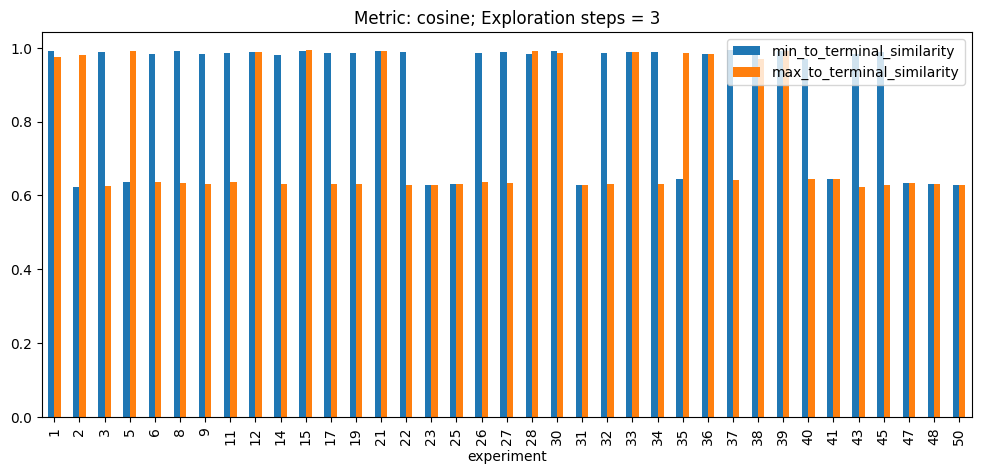

In [21]:
cosine_3k_df = visualization_df.loc[
    (visualization_df['type_of_similarity'] == 'cosine') & 
    (visualization_df['exploration_steps'] == 3)
][['experiment', 'min_to_terminal_similarity', 'max_to_terminal_similarity']]

plot = cosine_3k_df.plot(
    kind='bar',
    x='experiment', 
    y=['min_to_terminal_similarity', 'max_to_terminal_similarity'],
    title='Metric: cosine; Exploration steps = 3',
    figsize=(12, 5)
)
plt.show()

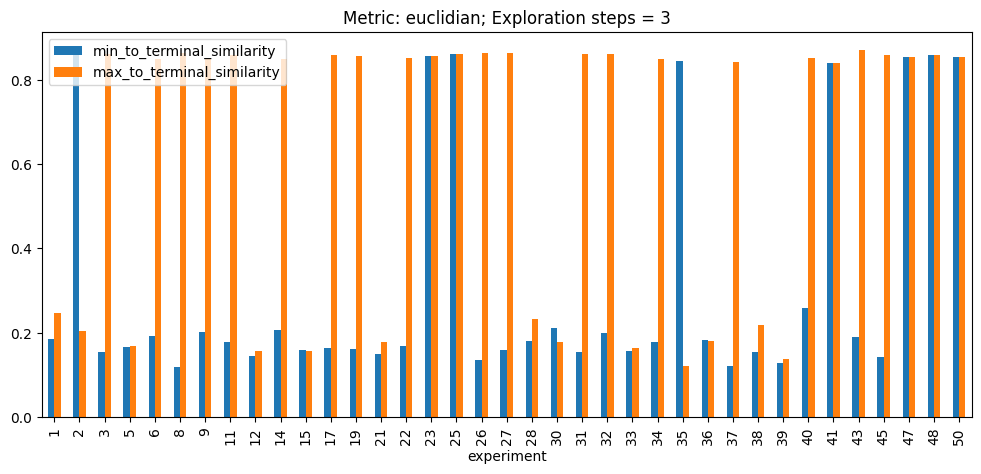

In [22]:
euclidian_3k_df = visualization_df.loc[
    (visualization_df['type_of_similarity'] == 'euclidian') & 
    (visualization_df['exploration_steps'] == 3)
][['experiment', 'min_to_terminal_similarity', 'max_to_terminal_similarity']]

plot = euclidian_3k_df.plot(
    kind='bar', 
    x='experiment', 
    y=['min_to_terminal_similarity', 'max_to_terminal_similarity'],
    title='Metric: euclidian; Exploration steps = 3',
    figsize=(12, 5)
)
plt.show()

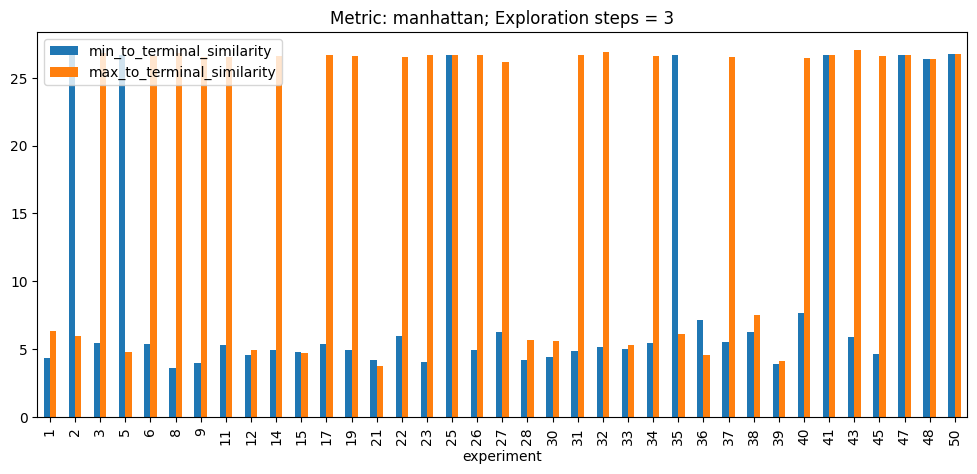

In [23]:
manhattan_3k_df = visualization_df.loc[
    (visualization_df['type_of_similarity'] == 'manhattan') & 
    (visualization_df['exploration_steps'] == 3)
][['experiment', 'min_to_terminal_similarity', 'max_to_terminal_similarity']]

plot = manhattan_3k_df.plot(
    kind='bar', 
    x='experiment', 
    y=['min_to_terminal_similarity', 'max_to_terminal_similarity'],
    title='Metric: manhattan; Exploration steps = 3',
    figsize=(12, 5)
)
plt.show()

In [24]:
k_values = visualization_df['exploration_steps'].unique()

In [25]:
for k in k_values:
    euclidian_df = visualization_df.loc[
        (visualization_df['type_of_similarity'] == 'euclidian') & 
        (visualization_df['exploration_steps'] == k)
    ]
    amount_of_success_experiments = len(euclidian_df.loc[euclidian_df['explanation_satisfied'] == True])
    amount_of_total_experiments = len(set(euclidian_df['experiment'].values))
    euclidian_success_percentage = round((amount_of_success_experiments / amount_of_total_experiments) * 100, 2)
    print(f"Euclidian success cases for {k} exploration steps: {euclidian_success_percentage}%")

Euclidian success cases for 1 exploration steps: 13.51%
Euclidian success cases for 2 exploration steps: 13.51%
Euclidian success cases for 3 exploration steps: 16.22%
Euclidian success cases for 4 exploration steps: 16.22%
Euclidian success cases for 5 exploration steps: 10.81%
Euclidian success cases for 6 exploration steps: 16.22%
Euclidian success cases for 7 exploration steps: 21.62%


In [26]:
for k in k_values:
    cosine_df = visualization_df.loc[
        (visualization_df['type_of_similarity'] == 'cosine') & 
        (visualization_df['exploration_steps'] == k)
    ]
    amount_of_success_experiments = len(cosine_df.loc[cosine_df['explanation_satisfied'] == True])
    amount_of_total_experiments = len(set(cosine_df['experiment'].values))
    cosine_success_percentage = round((amount_of_success_experiments / amount_of_total_experiments) * 100, 2)
    print(f"Cosine success cases for {k} exploration steps: {cosine_success_percentage}%")

Cosine success cases for 1 exploration steps: 67.57%
Cosine success cases for 2 exploration steps: 64.86%
Cosine success cases for 3 exploration steps: 62.16%
Cosine success cases for 4 exploration steps: 72.97%
Cosine success cases for 5 exploration steps: 64.86%
Cosine success cases for 6 exploration steps: 59.46%
Cosine success cases for 7 exploration steps: 59.46%


In [27]:
for k in k_values:
    manhattan_df = visualization_df.loc[
        (visualization_df['type_of_similarity'] == 'manhattan') & 
        (visualization_df['exploration_steps'] == k)
    ]
    amount_of_success_experiments = len(manhattan_df.loc[manhattan_df['explanation_satisfied'] == True])
    amount_of_total_experiments = len(set(manhattan_df['experiment'].values))
    manhattan_success_percentage = round((amount_of_success_experiments / amount_of_total_experiments) * 100, 2)
    print(f"Manhattan success cases for {k} exploration steps: {manhattan_success_percentage}%")

Manhattan success cases for 1 exploration steps: 10.81%
Manhattan success cases for 2 exploration steps: 16.22%
Manhattan success cases for 3 exploration steps: 18.92%
Manhattan success cases for 4 exploration steps: 13.51%
Manhattan success cases for 5 exploration steps: 13.51%
Manhattan success cases for 6 exploration steps: 21.62%
Manhattan success cases for 7 exploration steps: 29.73%


### Plots

In [28]:
# Grouping data by type_of_similarity and k, and calculate success rates
success_rates = experiments_df.groupby(['type_of_similarity', 'exploration_steps']).agg(
    total_experiments=('explanation_satisfied', 'count'),
    successful_experiments=('explanation_satisfied', 'sum')
).reset_index()

success_rates['success_rate'] = (success_rates['successful_experiments'] / success_rates['total_experiments']) * 100

# Displaying the calculated success rates
success_rates

,type_of_similarity,exploration_steps,total_experiments,successful_experiments,success_rate
0,cosine,1,37,25,67.567568
1,cosine,2,37,24,64.864865
2,cosine,3,37,23,62.162162
3,cosine,4,37,27,72.972973
4,cosine,5,37,24,64.864865
5,cosine,6,37,22,59.459459
6,cosine,7,37,22,59.459459
7,euclidian,1,37,5,13.513514
8,euclidian,2,37,5,13.513514
9,euclidian,3,37,6,16.216216


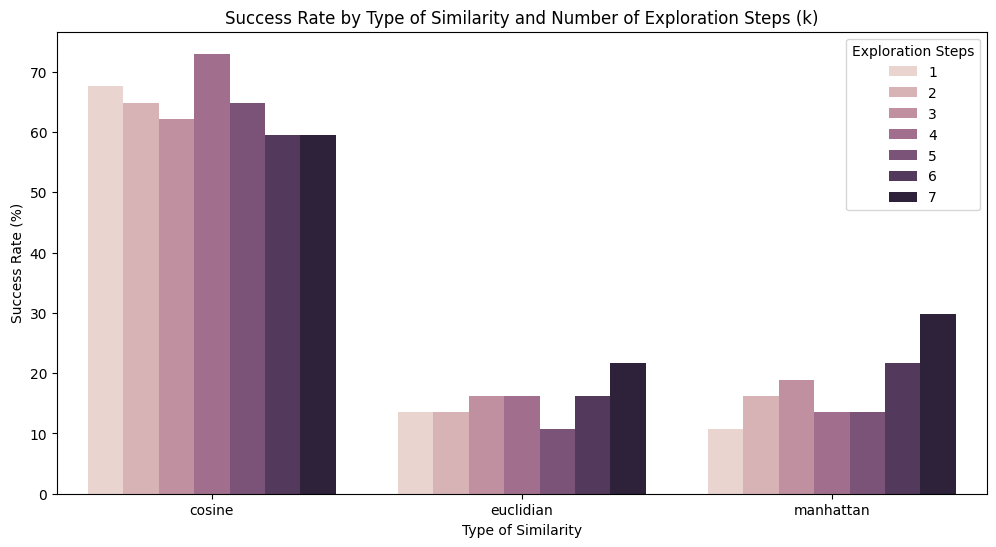

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Setting up the plot
plt.figure(figsize=(12, 6))
sns.barplot(data=success_rates, x='type_of_similarity', y='success_rate', hue='exploration_steps')
plt.title('Success Rate by Type of Similarity and Number of Exploration Steps (k)')
plt.xlabel('Type of Similarity')
plt.ylabel('Success Rate (%)')
plt.legend(title='Exploration Steps')
plt.show()

/var/folders/rp/5xgdthw53sn2b8gbxv7b0r240000gp/T/ipykernel_18479/4259157348.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cv_data, x='type_of_similarity', y='Coefficient_of_Variation', palette='viridis')


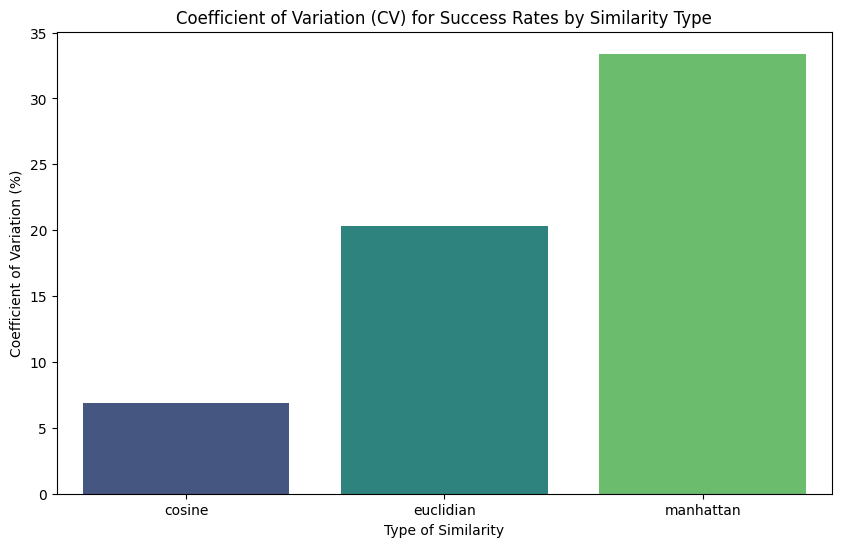

In [30]:
import numpy as np

# Re-calculating the Coefficient of Variation (CV) for each type of similarity
cv_data = success_rates.groupby('type_of_similarity')['success_rate'].apply(
    lambda x: np.std(x) / np.mean(x) * 100  # CV as a percentage
).reset_index().rename(columns={'success_rate': 'Coefficient_of_Variation'})

# Plotting the Coefficient of Variation
plt.figure(figsize=(10, 6))
sns.barplot(data=cv_data, x='type_of_similarity', y='Coefficient_of_Variation', palette='viridis')
plt.title('Coefficient of Variation (CV) for Success Rates by Similarity Type')
plt.xlabel('Type of Similarity')
plt.ylabel('Coefficient of Variation (%)')
plt.show()

### Best configuration

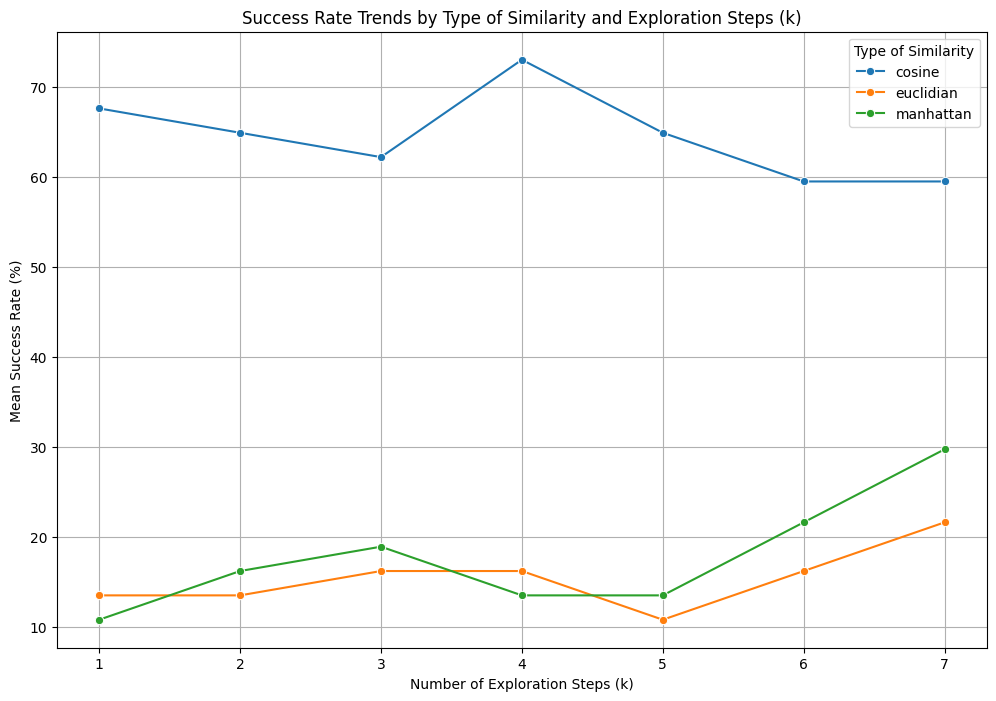

In [31]:
# Grouping the data by type of similarity and k, summarizing success rates
success_summary = experiments_df.groupby(['type_of_similarity', 'exploration_steps']).agg(
    mean_success_rate=('explanation_satisfied', lambda x: x.mean() * 100)
).reset_index()

# Plotting the success rate trends for each type of similarity across different k
plt.figure(figsize=(12, 8))
sns.lineplot(data=success_summary, x='exploration_steps', y='mean_success_rate', hue='type_of_similarity', marker='o')
plt.title('Success Rate Trends by Type of Similarity and Exploration Steps (k)')
plt.xlabel('Number of Exploration Steps (k)')
plt.ylabel('Mean Success Rate (%)')
plt.legend(title='Type of Similarity')
plt.grid(True)
plt.show()

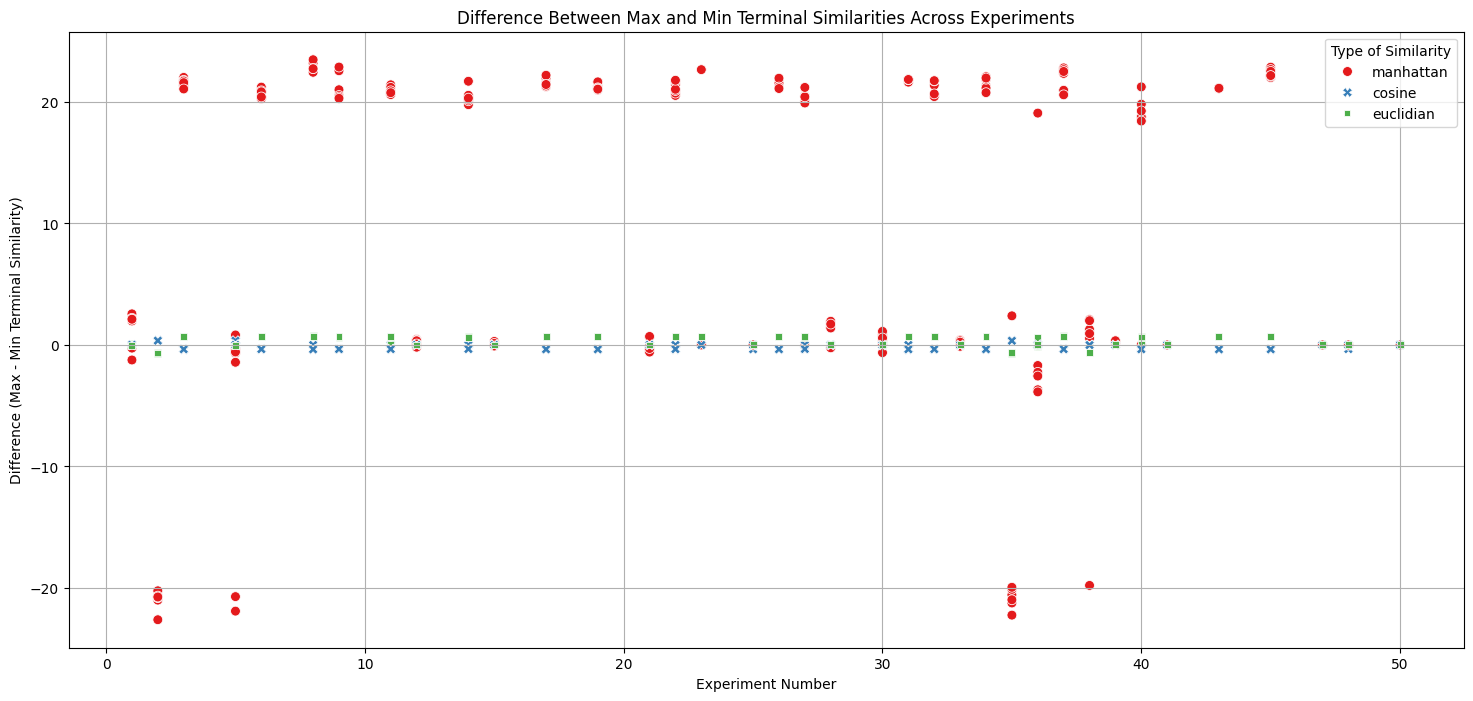

In [32]:
experiments_df['similarity_difference'] = experiments_df['max_to_terminal_similarity'] - experiments_df['min_to_terminal_similarity']

plt.figure(figsize=(18, 8))
sns.scatterplot(data=experiments_df, x='experiment', y='similarity_difference', hue='type_of_similarity', style='type_of_similarity', palette='Set1', s=50)
plt.title('Difference Between Max and Min Terminal Similarities Across Experiments')
plt.xlabel('Experiment Number')
plt.ylabel('Difference (Max - Min Terminal Similarity)')
plt.legend(title='Type of Similarity')
plt.grid(True)
plt.show()